In [1]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator 
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob
import sascorer
from sascorer import calculateScore

sns.set_theme(style="darkgrid")

## Import all data into single ipynb and draw the picture for them

### Data processing

Loading data from targetdiff and remove redundence based on inchi key

In [2]:
smi_list_targetdiff = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Targetdiff/combined_smiles_target_diff.txt') as f:
    for smi in f:
        smi_list_targetdiff.append(smi.strip())
canonical_smi_targetdiff = []
for smi in smi_list_targetdiff:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        canonical_smi_targetdiff.append(Chem.MolToSmiles(mol))

In [3]:
df_targetdiff = pd.DataFrame(canonical_smi_targetdiff, columns=['SMILES'])
df_targetdiff['mol'] = df_targetdiff.SMILES.apply(Chem.MolFromSmiles)
df_targetdiff.mol = df_targetdiff.mol.apply(uru.get_largest_fragment)
df_targetdiff['inchi'] = df_targetdiff.mol.apply(Chem.MolToInchi)
df_targetdiff = df_targetdiff.drop_duplicates("inchi", keep="first", ignore_index=True)
df_targetdiff

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefined stereo

[14:19:36] WARNING: Omitted undefi

SMILES  \
0       CN1C=NC2=C(C1)OC(C1=CC(O)C=CC1O)C2CCC(O)C(=O)O   
1    CC1CC(O)C(O)C(C2(C=C3NCC(F)O3)NC3=CC(=O)N(N)NC...   
2    O=CC(CC1CCNC1=O)c1cc(N2CC(O)OCC2=O)cc(C(F)(F)F)c1   
3           CNC(C(=O)O)C1C=CC(C(CC(F)F)CC(C)(O)O)C=C1F   
4    CCN(OCCN(CO)CCNC(=O)c1cccc(F)c1)C1C=CC=C(O)C(N...   
..                                                 ...   
960                   COC1C(O)CC2CC1C1NC(O)CC(O)C1CC2O   
961                         COCC(O)C(O)C(O)C(CO)C(N)=O   
962               CC1CC(CN)N2C1C1OC(C(=O)O)C(O)C(O)C12   
963                      CC1(CCC(O)C(=O)O)COC(O)COC1=O   
964                       CCCCC(O)C1=C(C(C)O)CNC(=O)N1   

                                                  mol  \
0    <rdkit.Chem.rdchem.Mol object at 0x793716fe3df0>   
1    <rdkit.Chem.rdchem.Mol object at 0x793716fe3d80>   
2    <rdkit.Chem.rdchem.Mol object at 0x793716fe3e60>   
3    <rdkit.Chem.rdchem.Mol object at 0x793716fe3ed0>   
4    <rdkit.Chem.rdchem.Mol object at 0x793716fe3f40>   
..                                                ...   
960  <rdkit.Chem.rdchem.Mol object at 0x793716ffef10>   
961  <rdkit.Chem.rdchem.Mol object at 0x793716ffef80>   
962  <rdkit.Chem.rdchem.Mol object at 0x793716ffeff0>   
963  <rdkit.Chem.rdchem.Mol object at 0x793716fff060>   
964  <rdkit.Chem.rdchem.Mol object at 0x793716fff0d0>   

                                                 inchi  
0    InChI=1S/C17H22N2O6/c1-19-7-14-15(18-8-19)10(3...  
1    InChI=1S/C19H26FN5O6/c1-7-3-10(26)16(28)15(8(7...  
2    InChI=1S/C18H19F3N2O5/c19-18(20,21)13-4-11(12(...  
3    InChI=1S/C15H22F3NO4/c1-15(22,23)7-9(6-12(17)1...  
4    InChI=1S/C25H35FN4O4/c1-2-30(22-9-6-10-24(32)2...  
..                                                 ...  
960  InChI=1S/C14H25NO5/c1-20-14-8-2-6(3-11(14)18)9...  
961  InChI=1S/C8H17NO6/c1-15-3-5(11)7(13)6(12)4(2-1...  
962  InChI=1S/C12H20N2O5/c1-4-2-5(3-13)14-6(4)10-7(...  
963  InChI=1S/C10H16O7/c1-10(3-2-6(11)8(13)14)5-17-...  
964  InChI=1S/C11H20N2O3/c1-3-4-5-9(15)10-8(7(2)14)...  

[965 rows x 3 columns]

Loading data from Pocket2mol and remove redundence based on inchi key

In [4]:
smi_list_p2m = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Pocket2mol/combined_SMILES_pocket2mol.txt') as f:
    for smi in f:
        smi_list_p2m.append(smi.strip())
canonical_smi_p2m = []
for smi in smi_list_p2m:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        canonical_smi_p2m.append(Chem.MolToSmiles(mol))

print(len(smi_list_p2m))
len(canonical_smi_p2m)

1345


1345

In [5]:
df_p2m = pd.DataFrame(canonical_smi_p2m, columns=['SMILES'])
df_p2m['mol'] = df_p2m.SMILES.apply(Chem.MolFromSmiles)
df_p2m.mol = df_p2m.mol.apply(uru.get_largest_fragment)
df_p2m['inchi'] = df_p2m.mol.apply(Chem.MolToInchi)
df_p2m = df_p2m.drop_duplicates("inchi", keep="first", ignore_index=True)
df_p2m

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Charges were rearranged

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Charges were rearranged

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefine

SMILES  \
0             O=C(O)C1C=CCC1   
1         Cc1nc(=O)n(O)[nH]1   
2            N=C1N=C(N)N=C1N   
3             NC(=O)c1ccccc1   
4              c1ccc2occc2c1   
...                      ...   
1100  NC(=O)c1c(N)cc[nH]c1=O   
1101     Cc1cc(C=O)cc(=O)n1O   
1102    O=C(O)c1cc(O)cc(O)c1   
1103      Cc1cc(O)ccc1C(=O)O   
1104    NC(=O)c1ccc(O)c(O)c1   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7937165838b0>   
1     <rdkit.Chem.rdchem.Mol object at 0x793716583840>   
2     <rdkit.Chem.rdchem.Mol object at 0x793716583920>   
3     <rdkit.Chem.rdchem.Mol object at 0x793716583990>   
4     <rdkit.Chem.rdchem.Mol object at 0x793716583a00>   
...                                                ...   
1100  <rdkit.Chem.rdchem.Mol object at 0x7937165a86d0>   
1101  <rdkit.Chem.rdchem.Mol object at 0x7937165a8740>   
1102  <rdkit.Chem.rdchem.Mol object at 0x7937165a8890>   
1103  <rdkit.Chem.rdchem.Mol object at 0x7937165a8900>   
1104  <rdkit.Chem.rdchem.Mol object at 0x7937165a8970>   

                                                  inchi  
0     InChI=1S/C6H8O2/c7-6(8)5-3-1-2-4-5/h1,3,5H,2,4...  
1     InChI=1S/C3H5N3O2/c1-2-4-3(7)6(8)5-2/h8H,1H3,(...  
2     InChI=1S/C3H5N5/c4-1-2(5)8-3(6)7-1/h(H5,4,5,6,...  
3     InChI=1S/C7H7NO/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H2...  
4           InChI=1S/C8H6O/c1-2-4-8-7(3-1)5-6-9-8/h1-6H  
...                                                 ...  
1100  InChI=1S/C6H7N3O2/c7-3-1-2-9-6(11)4(3)5(8)10/h...  
1101  InChI=1S/C7H7NO3/c1-5-2-6(4-9)3-7(10)8(5)11/h2...  
1102  InChI=1S/C7H6O4/c8-5-1-4(7(10)11)2-6(9)3-5/h1-...  
1103  InChI=1S/C8H8O3/c1-5-4-6(9)2-3-7(5)8(10)11/h2-...  
1104  InChI=1S/C7H7NO3/c8-7(11)4-1-2-5(9)6(10)3-4/h1...  

[1105 rows x 3 columns]

Loading data from pmdm and remove redundence based on inchi key

In [6]:
smi_list_pmdm = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/PMDM/PMDM_1000_control.smi') as f:
    for smi in f:
        smi_list_pmdm.append(smi.strip())
canonical_smi_pmdm = []
for smi in smi_list_pmdm:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        canonical_smi_pmdm.append(Chem.MolToSmiles(mol))

len(canonical_smi_pmdm)

[14:19:37] Explicit valence for atom # 6 N, 4, is greater than permitted
[14:19:37] Explicit valence for atom # 18 C, 5, is greater than permitted
[14:19:37] Explicit valence for atom # 7 C, 5, is greater than permitted
[14:19:37] Explicit valence for atom # 16 C, 5, is greater than permitted
[14:19:37] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:19:37] Explicit valence for atom # 7 C, 5, is greater than permitted
[14:19:37] Explicit valence for atom # 16 N, 4, is greater than permitted
[14:19:37] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:19:37] Explicit valence for atom # 20 C, 5, is greater than permitted
[14:19:37] Explicit valence for atom # 17 C, 5, is greater than permitted
[14:19:37] Explicit valence for atom # 10 N, 4, is greater than permitted


989

In [7]:
df_pmdm = pd.DataFrame(canonical_smi_pmdm, columns=['SMILES'])
df_pmdm['mol'] = df_pmdm.SMILES.apply(Chem.MolFromSmiles)
df_pmdm.mol = df_pmdm.mol.apply(uru.get_largest_fragment)
df_pmdm['inchi'] = df_pmdm.mol.apply(Chem.MolToInchi)
df_pmdm = df_pmdm.drop_duplicates("inchi", keep="first", ignore_index=True)
df_pmdm

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefined stereo

[14:19:37] WARNING: Omitted undefi

SMILES  \
0           CCC(O)C1CC(C2=C(O)CC(O)=C(F)C=C2)c2ccccc21   
1             C[P@](=O)(O)C1C[C@@]2(C=NC(=O)CC2O)OC1=N   
2    O=C1C2=C(O)C(O)C=C(O)C=C2c2cc3c(c(C(O)(O)O)c21...   
3                  NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21   
4    O=C1CC2CCC1CC1C[C@@](O)(CC3=CCC=CC=C3)c3ccccc3...   
..                                                 ...   
977       O=C1C2c3cc(O)c(O)cc3NCC2[C@@]23CC=CC(CC12)N3   
978  OC1=CC=C2C3=C(C=CC=CC13)NC1C(C3=CC=CC=CC3)C(O)...   
979     O=C(O)[C@@]1(C2=CC=CC(O)=CC2)CCC2CC1Nc1ccccc12   
980         C[C@]12NC=C(O)C(C(=O)O)C1CC1=CC=CC=CC1C2=O   
981             O=C1CCN2CC(c3cc(O)cc4c3CCC4)=C3CNC1C32   

                                                  mol  \
0    <rdkit.Chem.rdchem.Mol object at 0x7937165de730>   
1    <rdkit.Chem.rdchem.Mol object at 0x7937165de6c0>   
2    <rdkit.Chem.rdchem.Mol object at 0x7937165de7a0>   
3    <rdkit.Chem.rdchem.Mol object at 0x7937165de810>   
4    <rdkit.Chem.rdchem.Mol object at 0x7937165de880>   
..                                                ...   
977  <rdkit.Chem.rdchem.Mol object at 0x7937165f97e0>   
978  <rdkit.Chem.rdchem.Mol object at 0x7937165f9850>   
979  <rdkit.Chem.rdchem.Mol object at 0x7937165f98c0>   
980  <rdkit.Chem.rdchem.Mol object at 0x7937165f9930>   
981  <rdkit.Chem.rdchem.Mol object at 0x7937165f99a0>   

                                                 inchi  
0    InChI=1S/C19H21FO3/c1-2-17(21)15-9-14(11-5-3-4...  
1    InChI=1S/C9H13N2O5P/c1-17(14,15)5-3-9(16-8(5)1...  
2    InChI=1S/C20H14N2O8/c23-6-1-8-9-4-10-11-2-7(24...  
3    InChI=1S/C19H25NO/c20-16-10-15-14(13-2-1-3-17(...  
4    InChI=1S/C25H29NO2/c27-23-14-20-12-11-18(23)13...  
..                                                 ...  
977  InChI=1S/C17H18N2O3/c20-13-5-9-12(6-14(13)21)1...  
978  InChI=1S/C24H25NO5/c26-17-12-11-15-19-14(17)9-...  
979  InChI=1S/C20H21NO3/c22-15-5-3-4-14(8-9-15)20(1...  
980  InChI=1S/C16H17NO4/c1-16-11(13(15(20)21)12(18)...  
981  InChI=1S/C18H20N2O2/c21-11-6-10-2-1-3-12(10)13...  

[982 rows x 3 columns]

Loading data from Molsnapper and remove redundence based on inchi key

In [8]:
smi_list_molsnapper = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Molsnapper/smi_list_molsnapper_testset.smi') as f:
    for smi in f:
        smi_list_molsnapper.append(smi.strip())
canonical_smi_molsnapper = []
for smi in smi_list_molsnapper:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        canonical_smi_molsnapper.append(Chem.MolToSmiles(mol))

len(canonical_smi_molsnapper)

849

In [9]:
df_molsnapper = pd.DataFrame(canonical_smi_molsnapper, columns=['SMILES'])
df_molsnapper['mol'] = df_molsnapper.SMILES.apply(Chem.MolFromSmiles)
df_molsnapper.mol = df_molsnapper.mol.apply(uru.get_largest_fragment)
df_molsnapper['inchi'] = df_molsnapper.mol.apply(Chem.MolToInchi)
df_molsnapper = df_molsnapper.drop_duplicates("inchi", keep="first", ignore_index=True)
df_molsnapper

[14:19:38] WARNING: Omitted undefined stereo

[14:19:38] WARNING: Proton(s) added/removed

[14:19:38] WARNING: Omitted undefined stereo

[14:19:38] WARNING: Proton(s) added/removed

[14:19:38] WARNING: Proton(s) added/removed

[14:19:38] WARNING: Omitted undefined stereo

[14:19:38] WARNING: Omitted undefined stereo

[14:19:38] WARNING: Proton(s) added/removed; Omitted undefined stereo

[14:19:38] WARNING: Omitted undefined stereo

[14:19:38] WARNING: Proton(s) added/removed

[14:19:38] WARNING: Proton(s) added/removed; Omitted undefined stereo

[14:19:38] WARNING: Omitted undefined stereo

[14:19:38] WARNING: Proton(s) added/removed

[14:19:38] WARNING: Proton(s) added/removed

[14:19:38] WARNING: Omitted undefined stereo

[14:19:38] WARNING: Proton(s) added/removed

[14:19:38] WARNING: Proton(s) added/removed; Omitted undefined stereo

[14:19:38] WARNING: Omitted undefined stereo

[14:19:38] WARNING: Proton(s) added/removed; Omitted undefined stereo

[14:19:38] WARNING: Proton(s) add

SMILES  \
0    O=C(Nc1ccc(C(=O)NC2CCC3NCNC3C2)cc1)C(O)=Cc1ccc...   
1    O=C(CN1CCC2CC(NC(=O)Oc3ccc4c(c3)OCN4c3ccccc3)C...   
2    CCCNC1=CC=C2C(=O)N=C(OCCOC(=O)c3ccc(O)c(N=O)c3...   
3    Cc1ccc(C(=O)NNC(=O)[C@@H](NC(=O)C2=NC3=CC=CC3=...   
4                            NC(=O)[C@@H]1NN[C@H](N)N1   
..                                                 ...   
786  O=C(C=C(O)C(=O)Oc1ccc(C=NNC(=O)c2cccc(NC(=O)N3...   
787  CCO[C@@H]1NC(=N)N[C@@H](NC[C@H](N)[C@H](O)[C@@...   
788                   CNc1cc(O)ccc1OCOc1ccc(C(=O)O)cc1   
789      COc1c(C)cccc1CNC(=O)c1ccc(NC(=O)Cc2ccncc2)cc1   
790               O=C1CN(S(=O)(=O)c2ccccc2)Cc2ccccc2N1   

                                                  mol  \
0    <rdkit.Chem.rdchem.Mol object at 0x793711b22ea0>   
1    <rdkit.Chem.rdchem.Mol object at 0x793711b5e650>   
2    <rdkit.Chem.rdchem.Mol object at 0x793711b5e5e0>   
3    <rdkit.Chem.rdchem.Mol object at 0x793711b5e6c0>   
4    <rdkit.Chem.rdchem.Mol object at 0x793711b5e730>   
..                                                ...   
786  <rdkit.Chem.rdchem.Mol object at 0x793711b759a0>   
787  <rdkit.Chem.rdchem.Mol object at 0x793711b75a10>   
788  <rdkit.Chem.rdchem.Mol object at 0x793711b75a80>   
789  <rdkit.Chem.rdchem.Mol object at 0x793711b75af0>   
790  <rdkit.Chem.rdchem.Mol object at 0x793711b75b60>   

                                                 inchi  
0    InChI=1S/C31H30N6O5/c38-27(15-18-5-12-22(13-6-...  
1    InChI=1S/C30H29N5O6/c36-26(31-20-7-3-1-4-8-20)...  
2    InChI=1S/C22H21N3O7/c1-3-8-23-15-6-5-14-18(19(...  
3    InChI=1S/C19H16N4O5/c1-10-5-7-11(8-6-10)16(24)...  
4    InChI=1S/C3H9N5O/c4-1(9)2-6-3(5)8-7-2/h2-3,6-8...  
..                                                 ...  
786  InChI=1S/C30H29N5O6/c36-26(19-27(37)32-23-9-3-...  
787  InChI=1S/C19H39N9O9S/c1-2-35-16-13(33)15(27-17...  
788  InChI=1S/C15H15NO5/c1-16-13-8-11(17)4-7-14(13)...  
789  InChI=1S/C23H23N3O3/c1-16-4-3-5-19(22(16)29-2)...  
790  InChI=1S/C15H14N2O3S/c18-15-11-17(10-12-6-4-5-...  

[791 rows x 3 columns]

Loading data from FDA approved sm drug and remove redundence based on inchi key

In [10]:
smi_list_fda = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/FDA_approve_sm_molecules/drugbank_smdrugs_smiles.txt') as f:
    for smi in f:
        smi_list_fda.append(smi.strip())
canonical_smi_fda = []
for smi in smi_list_fda:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        canonical_smi_fda.append(Chem.MolToSmiles(mol))

len(canonical_smi_fda)

[14:19:39] WARNING: not removing hydrogen atom without neighbors
[14:19:39] WARNING: not removing hydrogen atom without neighbors
[14:19:39] WARNING: not removing hydrogen atom without neighbors


2778

In [11]:
df_fda= pd.DataFrame(canonical_smi_fda, columns=['SMILES'])
df_fda['mol'] = df_fda.SMILES.apply(Chem.MolFromSmiles)
df_fda.mol = df_fda.mol.apply(uru.get_largest_fragment)
df_fda['inchi'] = df_fda.mol.apply(Chem.MolToInchi)
df_fda = df_fda.drop_duplicates("inchi", keep="first", ignore_index=True)
df_fda

[14:19:39] WARNING: not removing hydrogen atom without neighbors
[14:19:39] WARNING: not removing hydrogen atom without neighbors
[14:19:39] WARNING: not removing hydrogen atom without neighbors
[14:19:40] WARNING: Omitted undefined stereo

[14:19:40] WARNING: Proton(s) added/removed

[14:19:40] WARNING: Omitted undefined stereo

[14:19:40] WARNING: Omitted undefined stereo

[14:19:40] WARNING: Omitted undefined stereo

[14:19:40] WARNING: Omitted undefined stereo

[14:19:40] WARNING: Omitted undefined stereo

[14:19:40] WARNING: Omitted undefined stereo

[14:19:40] WARNING: Omitted undefined stereo

[14:19:40] WARNING: Omitted undefined stereo

[14:19:40] WARNING: Proton(s) added/removed

[14:19:40] WARNING: Omitted undefined stereo

[14:19:40] WARNING: Omitted undefined stereo

[14:19:40] WARNING: Omitted undefined stereo

[14:19:40] WARNING: Omitted undefined stereo

[14:19:40] WARNING: Omitted undefined stereo

[14:19:40] WARNING: Omitted undefined stereo

[14:19:40] WARNING: Proto

SMILES  \
0     CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...   
1     CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...   
2     CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...   
3     CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...   
4     N=C(O)CC[C@@H]1N=C(O)[C@H](Cc2ccccc2)N=C(O)[C@...   
...                                                 ...   
2646  CCCCCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...   
2647  CC(C)(C)[Si]([18F])(c1ccc(C(=O)NC[C@@H](N=C(O)...   
2648  Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...   
2649                CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C   
2650  C[n+]1ccn(C[C@]2(C)[C@H](C(=O)[O-])N3C(=O)C[C@...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x793711164f20>   
1     <rdkit.Chem.rdchem.Mol object at 0x793711164eb0>   
2     <rdkit.Chem.rdchem.Mol object at 0x793711164f90>   
3     <rdkit.Chem.rdchem.Mol object at 0x793711165000>   
4     <rdkit.Chem.rdchem.Mol object at 0x793711165070>   
...                                                ...   
2646  <rdkit.Chem.rdchem.Mol object at 0x7937111b55b0>   
2647  <rdkit.Chem.rdchem.Mol object at 0x7937111b5620>   
2648  <rdkit.Chem.rdchem.Mol object at 0x7937111b5690>   
2649  <rdkit.Chem.rdchem.Mol object at 0x7937111b5700>   
2650  <rdkit.Chem.rdchem.Mol object at 0x7937111b5770>   

                                                  inchi  
0     InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...  
1     InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...  
2     InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...  
3     InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...  
4     InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...  
...                                                 ...  
2646  InChI=1S/C14H17F13/c1-2-3-4-5-6-7-8-9(15,16)10...  
2647  InChI=1S/C63H99FN12O25Si/c1-62(2,3)102(64,63(4...  
2648  InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...  
2649  InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...  
2650  InChI=1S/C11H14N4O5S/c1-11(6-14-4-3-13(2)12-14...  

[2651 rows x 3 columns]

Loading data from Decompdiff and remove redundence based on inchi key

In [12]:
smi_list_decompdiff = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Decompdiff/combined_smiles_decompdiff.smi') as f:
    for smi in f:
        smi_list_decompdiff.append(smi.strip())
canonical_smi_decompdiff = []
for smi in smi_list_decompdiff:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        canonical_smi_decompdiff.append(Chem.MolToSmiles(mol))

print(len(smi_list_decompdiff))
len(canonical_smi_decompdiff)

884


884

In [13]:
df_decompdiff= pd.DataFrame(canonical_smi_decompdiff, columns=['SMILES'])
df_decompdiff['mol'] = df_decompdiff.SMILES.apply(Chem.MolFromSmiles)
df_decompdiff.mol = df_decompdiff.mol.apply(uru.get_largest_fragment)
df_decompdiff['inchi'] = df_decompdiff.mol.apply(Chem.MolToInchi)
df_decompdiff = df_decompdiff.drop_duplicates("inchi", keep="first", ignore_index=True)
df_decompdiff

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefined stereo

[14:19:41] WARNING: Omitted undefi

SMILES  \
0                                      Oc1cccc2ccccc12   
1                                  CC1NCC(C(N)=O)=CC1O   
2                                      C1CCC2NCNCCC2C1   
3                                   c1ccc(-c2nccs2)cc1   
4                                      Oc1ccc2ccccc2c1   
..                                                 ...   
849  Nc1ncnc2n(C3OC(O)C(O)C3COP(=O)(O)OP(=O)(O)O)c=...   
850  Nc1ncc2c(n1)N(C1CC(O)C(CO[PH](=O)(O)(O)O[PH](=...   
851  CC1CC(CC2CCN3C(=N)C(=O)N=C23)CC1COP(=O)(O)OP(=...   
852  CC1OC(C2NCNC3NC(N)NC32)C(OP(=O)(O)OP(=O)(O)O)CC1O   
853  NS(=O)(=O)C1CCN(COC(O)CNCCC(CP(=O)(O)O)C(=O)O)CC1   

                                                  mol  \
0    <rdkit.Chem.rdchem.Mol object at 0x79370e727b50>   
1    <rdkit.Chem.rdchem.Mol object at 0x79370e727ae0>   
2    <rdkit.Chem.rdchem.Mol object at 0x79370e727bc0>   
3    <rdkit.Chem.rdchem.Mol object at 0x79370e727c30>   
4    <rdkit.Chem.rdchem.Mol object at 0x79370e727ca0>   
..                                                ...   
849  <rdkit.Chem.rdchem.Mol object at 0x79370e73fed0>   
850  <rdkit.Chem.rdchem.Mol object at 0x79370e73ff40>   
851  <rdkit.Chem.rdchem.Mol object at 0x79370e740040>   
852  <rdkit.Chem.rdchem.Mol object at 0x79370e7400b0>   
853  <rdkit.Chem.rdchem.Mol object at 0x79370e740120>   

                                                 inchi  
0    InChI=1S/C10H8O/c11-10-7-3-5-8-4-1-2-6-9(8)10/...  
1    InChI=1S/C7H12N2O2/c1-4-6(10)2-5(3-9-4)7(8)11/...  
2    InChI=1S/C9H18N2/c1-2-4-9-8(3-1)5-6-10-7-11-9/...  
3    InChI=1S/C9H7NS/c1-2-4-8(5-3-1)9-10-6-7-11-9/h...  
4    InChI=1S/C10H8O/c11-10-6-5-8-3-1-2-4-9(8)7-10/...  
..                                                 ...  
849  InChI=1S/C10H15N5O10P2/c11-10-12-1-5-7(13-3-14...  
850  InChI=1S/C12H21N4O9P2/c13-12-14-4-6-1-2-16(11(...  
851  InChI=1S/C14H23N3O8P2/c1-8-4-9(5-10-2-3-17-12(...  
852  InChI=1S/C11H25N5O9P2/c1-4-5(17)2-6(24-27(21,2...  
853  InChI=1S/C13H28N3O9PS/c14-27(23,24)11-2-5-16(6...  

[854 rows x 3 columns]

Loading data from Decompopt and remove redundence based on inchi key

In [14]:
smi_list_decompopt = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Decomopt/combined_smiles_decompopt.smi') as f:
    for smi in f:
        smi_list_decompopt.append(smi.strip())
canonical_smi_decompopt = []
for smi in smi_list_decompopt:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        canonical_smi_decompopt.append(Chem.MolToSmiles(mol))

print(len(smi_list_decompopt))
len(canonical_smi_decompopt)

913


913

In [15]:
df_decompopt= pd.DataFrame(canonical_smi_decompopt, columns=['SMILES'])
df_decompopt['mol'] = df_decompopt.SMILES.apply(Chem.MolFromSmiles)
df_decompopt.mol = df_decompopt.mol.apply(uru.get_largest_fragment)
df_decompopt['inchi'] = df_decompopt.mol.apply(Chem.MolToInchi)
df_decompopt = df_decompopt.drop_duplicates("inchi", keep="first", ignore_index=True)
df_decompopt

[14:19:42] WARNING: Omitted undefined stereo

[14:19:42] WARNING: Omitted undefined stereo

[14:19:42] WARNING: Omitted undefined stereo

[14:19:42] WARNING: Proton(s) added/removed; Omitted undefined stereo

[14:19:42] WARNING: Omitted undefined stereo

[14:19:42] WARNING: Omitted undefined stereo

[14:19:42] WARNING: Omitted undefined stereo

[14:19:42] WARNING: Omitted undefined stereo

[14:19:42] WARNING: Omitted undefined stereo

[14:19:42] WARNING: Omitted undefined stereo

[14:19:42] WARNING: Omitted undefined stereo

[14:19:42] WARNING: Omitted undefined stereo

[14:19:42] WARNING: Omitted undefined stereo

[14:19:42] WARNING: Omitted undefined stereo

[14:19:42] WARNING: Omitted undefined stereo

[14:19:42] WARNING: Omitted undefined stereo

[14:19:42] WARNING: Omitted undefined stereo

[14:19:42] WARNING: Omitted undefined stereo

[14:19:42] WARNING: Omitted undefined stereo

[14:19:42] WARNING: Omitted undefined stereo

[14:19:42] WARNING: Omitted undefined stereo

[14:19:42

SMILES  \
0    CN1CC(C(CO)CC(C(=O)O)c2ccc(N3CCOC3=O)s2)C(CCC2...   
1    CCCOc1cc2c(cc1C(=O)NCC(NC(C)=O)C(O)CNc1ncc(C)o...   
2    CC(=O)n1cc(C2C=C(O)CCC2)c(NC(=O)c2cc(C(C)c3ccc...   
3    CCCCC(C1=CC2=C(N3CCC(C)C3)N=[N+](C)C2=C1C(=O)O...   
4    C=C(C)OC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)n1ccc(...   
..                                                 ...   
882                                NC1CC2C(N)CCCNC2C1O   
883                             O=C(O)C1C(O)CC(O)CC1CO   
884                              OC1OOC2CCC(O)(C1O)C2O   
885                                OCCC1(O)C(O)CCCCC1O   
886                              OCC1CC(O)C(O)CC(O)C1O   

                                                  mol  \
0    <rdkit.Chem.rdchem.Mol object at 0x79370e799b60>   
1    <rdkit.Chem.rdchem.Mol object at 0x79370e799bd0>   
2    <rdkit.Chem.rdchem.Mol object at 0x79370e799c40>   
3    <rdkit.Chem.rdchem.Mol object at 0x79370e799cb0>   
4    <rdkit.Chem.rdchem.Mol object at 0x79370e799d20>   
..                                                ...   
882  <rdkit.Chem.rdchem.Mol object at 0x79370e7b2b90>   
883  <rdkit.Chem.rdchem.Mol object at 0x79370e7b2c00>   
884  <rdkit.Chem.rdchem.Mol object at 0x79370e7b2c70>   
885  <rdkit.Chem.rdchem.Mol object at 0x79370e7b2ce0>   
886  <rdkit.Chem.rdchem.Mol object at 0x79370e7b2d50>   

                                                 inchi  
0    InChI=1S/C23H33N3O7S/c1-23(12-25(32)13-23)6-5-...  
1    InChI=1S/C22H30N6O6/c1-4-5-33-19-7-16-14(9-24-...  
2    InChI=1S/C26H27N3O5/c1-15(17-7-4-3-5-8-17)19-1...  
3    InChI=1S/C25H36N6O3/c1-4-5-6-15(19-8-7-18(23(3...  
4    InChI=1S/C25H38N6O3/c1-15(2)34-24(31-11-8-19(1...  
..                                                 ...  
882  InChI=1S/C9H19N3O/c10-6-2-1-3-12-8-5(6)4-7(11)...  
883  InChI=1S/C8H14O5/c9-3-4-1-5(10)2-6(11)7(4)8(12...  
884  InChI=1S/C7H12O6/c8-4-3-1-2-7(4,11)5(9)6(10)13...  
885  InChI=1S/C9H18O4/c10-6-5-9(13)7(11)3-1-2-4-8(9...  
886  InChI=1S/C8H16O5/c9-3-4-1-5(10)6(11)2-7(12)8(4...  

[887 rows x 3 columns]

Loading data from Crossdock and remove redundence based on inchi key

In [16]:
smi_list_crossdock = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Crossdock_datasets/crossdock_ligand_smi.smi') as f:
    for smi in f:
        smi_list_crossdock.append(smi.strip())
canonical_smi_crossdock = []
for smi in smi_list_crossdock:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        canonical_smi_crossdock.append(Chem.MolToSmiles(mol))

print(len(smi_list_crossdock))
len(canonical_smi_crossdock)

11602


11602

In [17]:
df_crossdock= pd.DataFrame(canonical_smi_crossdock, columns=['SMILES'])
df_crossdock['mol'] = df_crossdock.SMILES.apply(Chem.MolFromSmiles)
df_crossdock.mol = df_crossdock.mol.apply(uru.get_largest_fragment)
df_crossdock['inchi'] = df_crossdock.mol.apply(Chem.MolToInchi)
df_crossdock = df_crossdock.drop_duplicates("inchi", keep="first", ignore_index=True)
df_crossdock

[14:19:48] WARNING: Charges were rearranged

[14:19:48] WARNING: Charges were rearranged

[14:19:48] WARNING: Charges were rearranged

[14:19:48] WARNING: Omitted undefined stereo

[14:19:48] WARNING: Omitted undefined stereo

[14:19:48] WARNING: Omitted undefined stereo

[14:19:48] WARNING: Charges were rearranged

[14:19:48] WARNING: Omitted undefined stereo

[14:19:48] WARNING: Omitted undefined stereo

[14:19:48] WARNING: Omitted undefined stereo

[14:19:48] WARNING: Charges were rearranged

[14:19:48] WARNING: Omitted undefined stereo

[14:19:48] WARNING: Omitted undefined stereo

[14:19:48] WARNING: Omitted undefined stereo

[14:19:48] WARNING: Omitted undefined stereo

[14:19:48] WARNING: Omitted undefined stereo

[14:19:48] WARNING: Omitted undefined stereo

[14:19:48] WARNING: Omitted undefined stereo

[14:19:48] WARNING: Omitted undefined stereo

[14:19:48] WARNING: Charges were rearranged

[14:19:48] WARNING: Charges were rearranged

[14:19:48] WARNING: Omitted undefined ste

SMILES  \
0      CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC[C@H]3C...   
1      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
2      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
3      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OP(=...   
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...   
...                                                  ...   
11597                    C=C/C=C/[C@@]1(C)SC(=O)C(C)=C1O   
11598                          NC[C@@H](O)c1ccc(O)c(O)c1   
11599                              N[C@H](C=O)CC1=NC=NC1   
11600  Nc1ncnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O)[C@...   
11601  Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OC(=...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x793701f659a0>   
1      <rdkit.Chem.rdchem.Mol object at 0x793701f65a10>   
2      <rdkit.Chem.rdchem.Mol object at 0x793701f65a80>   
3      <rdkit.Chem.rdchem.Mol object at 0x793701f65af0>   
4      <rdkit.Chem.rdchem.Mol object at 0x793701f65b60>   
...                                                 ...   
11597  <rdkit.Chem.rdchem.Mol object at 0x7937015a5850>   
11598  <rdkit.Chem.rdchem.Mol object at 0x7937015a58c0>   
11599  <rdkit.Chem.rdchem.Mol object at 0x7937015a5930>   
11600  <rdkit.Chem.rdchem.Mol object at 0x7937015a59a0>   
11601  <rdkit.Chem.rdchem.Mol object at 0x7937015a5a10>   

                                                   inchi  
0      InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...  
1      InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...  
2      InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...  
3      InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-8)15(...  
4      InChI=1S/C27H19N3O5/c1-26-27(33,25(32)34-2)11-...  
...                                                  ...  
11597  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...  
11598  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...  
11599  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h3-5H...  
11600  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...  
11601  InChI=1S/C16H21N8O8P/c17-8(1-7-2-19-4-20-7)16(...  

[11602 rows x 3 columns]

Loading data from ChEMBL and remove redundence based on inchi key

In [18]:
# Initialize an empty list to store SMILES and file names
data_ChEMBL = []
counts = 0
sdf_files_ChEMBL = glob.glob('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/ChEMBL_clinical_smmolecules/*.sdf')
# Loop over each SDF file
for sdf_file in sdf_files_ChEMBL:
    # Read the SDF file
    supplier = Chem.SDMolSupplier(sdf_file)
    
    # Extract SMILES from each molecule in the SDF file
    for mol in supplier:
        counts += 1
        if mol is not None:  # Ensure the molecule is valid
            smiles = Chem.MolToSmiles(mol)
            # Append the SMILES and the filename to the data list
            data_ChEMBL.append({"File Name": sdf_file, "SMILES": smiles})

### Make sure 1000 molecules are generated and calculated
print(counts)
len(data_ChEMBL)
smi_list_ChEMBL = [x['SMILES'] for x in data_ChEMBL]

[14:19:53] WARNING: not removing hydrogen atom without neighbors
[14:19:53] WARNING: not removing hydrogen atom without neighbors
[14:19:53] WARNING: not removing hydrogen atom without neighbors
[14:19:53] WARNING: not removing hydrogen atom without neighbors


8236


In [19]:
df_ChEMBL= pd.DataFrame(data_ChEMBL)
df_ChEMBL['mol'] = df_ChEMBL.SMILES.apply(Chem.MolFromSmiles)
df_ChEMBL.mol = df_ChEMBL.mol.apply(uru.get_largest_fragment)
df_ChEMBL['inchi'] = df_ChEMBL.mol.apply(Chem.MolToInchi)
df_ChEMBL = df_ChEMBL.drop_duplicates("inchi", keep="first", ignore_index=True)
df_ChEMBL

[14:19:55] WARNING: not removing hydrogen atom without neighbors
[14:19:55] WARNING: not removing hydrogen atom without neighbors
[14:19:55] WARNING: not removing hydrogen atom without neighbors
[14:19:55] WARNING: not removing hydrogen atom without neighbors
[14:19:56] WARNING: Omitted undefined stereo

[14:19:56] WARNING: Omitted undefined stereo

[14:19:56] WARNING: Omitted undefined stereo

[14:19:56] WARNING: Omitted undefined stereo

[14:19:56] WARNING: Omitted undefined stereo

[14:19:56] WARNING: Omitted undefined stereo

[14:19:56] WARNING: Omitted undefined stereo

[14:19:56] WARNING: Omitted undefined stereo

[14:19:56] WARNING: Omitted undefined stereo

[14:19:56] WARNING: Proton(s) added/removed

[14:19:56] WARNING: Omitted undefined stereo

[14:19:56] WARNING: Omitted undefined stereo

[14:19:56] WARNING: Proton(s) added/removed

[14:19:56] WARNING: Omitted undefined stereo

[14:19:56] WARNING: Omitted undefined stereo

[14:19:56] WARNING: Omitted undefined stereo

[14:19

File Name  \
0     /home/yang2531/Documents/Bo_toolbox/PatWalters...   
1     /home/yang2531/Documents/Bo_toolbox/PatWalters...   
2     /home/yang2531/Documents/Bo_toolbox/PatWalters...   
3     /home/yang2531/Documents/Bo_toolbox/PatWalters...   
4     /home/yang2531/Documents/Bo_toolbox/PatWalters...   
...                                                 ...   
7695  /home/yang2531/Documents/Bo_toolbox/PatWalters...   
7696  /home/yang2531/Documents/Bo_toolbox/PatWalters...   
7697  /home/yang2531/Documents/Bo_toolbox/PatWalters...   
7698  /home/yang2531/Documents/Bo_toolbox/PatWalters...   
7699  /home/yang2531/Documents/Bo_toolbox/PatWalters...   

                                                 SMILES  \
0            CN(C)CC1CCCCC1(O)c1cccc(OC(=O)c2ccccc2O)c1   
1     Cc1cc(C(=O)NCCc2ccc(S(=O)(=O)NC(=O)NC3CCCCC3)c...   
2                        O=C1NC(=O)C2(c3ccc(Cl)cc3)CC12   
3      CC(C)C(=O)Oc1cc(OC(=O)C(C)C)cc(C(O)CNC(C)(C)C)c1   
4     CCOC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@]1(O...   
...                                                 ...   
7695          CC(C)Cc1ccc([C@@H](C)C(=O)NS(C)(=O)=O)cc1   
7696                     CC(C)(C)NCC(O)COc1cc(Cl)ccc1Cl   
7697            CCc1nc2c(N)nc3ccccc3c2n1CCCCNS(C)(=O)=O   
7698  CC[C@H]1[C@@H]2C[C@H]3[C@@H]4N(C)c5ccccc5[C@]4...   
7699  Cn1c(-c2ccccn2)c(C2CCCC2)c2ccc(C(=O)NC3(C(=O)N...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7936f4d762d0>   
1     <rdkit.Chem.rdchem.Mol object at 0x7936f97f0ba0>   
2     <rdkit.Chem.rdchem.Mol object at 0x7936f4dd8040>   
3     <rdkit.Chem.rdchem.Mol object at 0x7936f4dd80b0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7936f4dd8120>   
...                                                ...   
7695  <rdkit.Chem.rdchem.Mol object at 0x7936f23baf80>   
7696  <rdkit.Chem.rdchem.Mol object at 0x7936f23baff0>   
7697  <rdkit.Chem.rdchem.Mol object at 0x7936f23bb0d0>   
7698  <rdkit.Chem.rdchem.Mol object at 0x7936f23bb140>   
7699  <rdkit.Chem.rdchem.Mol object at 0x7936f23bb1b0>   

                                                  inchi  
0     InChI=1S/C22H27NO4/c1-23(2)15-17-8-5-6-13-22(1...  
1     InChI=1S/C20H26N4O5S/c1-14-13-18(23-29-14)19(2...  
2     InChI=1S/C11H8ClNO2/c12-7-3-1-6(2-4-7)11-5-8(1...  
3     InChI=1S/C20H31NO5/c1-12(2)18(23)25-15-8-14(17...  
4     InChI=1S/C56H68N6O9/c1-7-52(67)28-33-29-55(51(...  
...                                                 ...  
7695  InChI=1S/C14H21NO3S/c1-10(2)9-12-5-7-13(8-6-12...  
7696  InChI=1S/C13H19Cl2NO2/c1-13(2,3)16-7-10(17)8-1...  
7697  InChI=1S/C17H23N5O2S/c1-3-14-21-15-16(12-8-4-5...  
7698  InChI=1S/C20H26N2O2/c1-3-10-11-8-14-17-20(12-6...  
7699  InChI=1S/C34H34N4O4/c1-38-28-21-24(13-16-26(28...  

[7700 rows x 4 columns]

Loading data from 3D_generative_SBDD and remove redundence based on inchi key

In [20]:
smi_list_3DSBDD = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/3D_generative_SBDD/combined_SMILES_3D_generative.txt') as f:
    for smi in f:
        smi_list_3DSBDD.append(smi.strip())
canonical_smi_3DSBDD = []
for smi in smi_list_3DSBDD:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        canonical_smi_3DSBDD.append(Chem.MolToSmiles(mol))

print(len(smi_list_3DSBDD))
len(canonical_smi_3DSBDD)

[14:20:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6
[14:20:00] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6 8
[14:20:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[14:20:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[14:20:00] Explicit valence for atom # 3 N, 4, is greater than permitted
[14:20:00] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:20:00] Explicit valence for atom # 6 N, 4, is greater than permitted
[14:20:00] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:20:00] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:20:00] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[14:20:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[14:20:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7
[14:20:00] Explicit valence for atom # 4 N, 4, is greater than permitted


1750


[14:20:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 8 9 11 12
[14:20:00] Explicit valence for atom # 13 N, 4, is greater than permitted
[14:20:00] Explicit valence for atom # 13 N, 4, is greater than permitted
[14:20:00] Explicit valence for atom # 14 N, 4, is greater than permitted
[14:20:00] Explicit valence for atom # 14 N, 4, is greater than permitted


1732

In [21]:
df_3DSBDD= pd.DataFrame(canonical_smi_3DSBDD, columns=['SMILES'])
df_3DSBDD['mol'] = df_3DSBDD.SMILES.apply(Chem.MolFromSmiles)
df_3DSBDD.mol = df_3DSBDD.mol.apply(uru.get_largest_fragment)
df_3DSBDD['inchi'] = df_3DSBDD.mol.apply(Chem.MolToInchi)
df_3DSBDD = df_3DSBDD.drop_duplicates("inchi", keep="first", ignore_index=True)
df_3DSBDD

[14:20:00] WARNING: Omitted undefined stereo

[14:20:00] WARNING: Omitted undefined stereo

[14:20:00] WARNING: Omitted undefined stereo

[14:20:00] WARNING: Omitted undefined stereo

[14:20:00] WARNING: Accepted unusual valence(s): N(2); Omitted undefined stereo

[14:20:00] WARNING: Omitted undefined stereo

[14:20:00] WARNING: Omitted undefined stereo

[14:20:00] WARNING: Accepted unusual valence(s): N(2); Omitted undefined stereo

[14:20:00] WARNING: Accepted unusual valence(s): N(2); Omitted undefined stereo

[14:20:00] WARNING: Omitted undefined stereo

[14:20:00] WARNING: Omitted undefined stereo

[14:20:00] WARNING: Omitted undefined stereo

[14:20:00] WARNING: Omitted undefined stereo

[14:20:00] WARNING: Omitted undefined stereo

[14:20:00] WARNING: Omitted undefined stereo

[14:20:00] WARNING: Omitted undefined stereo

[14:20:00] WARNING: Omitted undefined stereo

[14:20:00] WARNING: Omitted undefined stereo

[14:20:00] WARNING: Omitted undefined stereo

[14:20:00] WARNING: A

SMILES  \
0                       OC1CCCN1   
1                     OC1C=CC=N1   
2              CC(C)CNNCC(C)(N)O   
3           CC1(O)NCCC1NCC1CCCN1   
4     CC(N)(O)C([NH])NCC1CC=CCC1   
...                          ...   
1496               OC[PH](O)(O)O   
1497                 COP(=O)(O)O   
1498             CC(C)OP(=O)(O)O   
1499           O=P(O)(O)OCCC1CN1   
1500        O=P(O)(O)OCC1=CN=NC1   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7936ef9c77d0>   
1     <rdkit.Chem.rdchem.Mol object at 0x7936ef9c7840>   
2     <rdkit.Chem.rdchem.Mol object at 0x7936ef9c78b0>   
3     <rdkit.Chem.rdchem.Mol object at 0x7936ef9c7920>   
4     <rdkit.Chem.rdchem.Mol object at 0x7936ef9c7990>   
...                                                ...   
1496  <rdkit.Chem.rdchem.Mol object at 0x7936ef9f7060>   
1497  <rdkit.Chem.rdchem.Mol object at 0x7936ef9f70d0>   
1498  <rdkit.Chem.rdchem.Mol object at 0x7936ef9f7220>   
1499  <rdkit.Chem.rdchem.Mol object at 0x7936ef9f7300>   
1500  <rdkit.Chem.rdchem.Mol object at 0x7936ef9f7370>   

                                                  inchi  
0            InChI=1S/C4H9NO/c6-4-2-1-3-5-4/h4-6H,1-3H2  
1                InChI=1S/C4H5NO/c6-4-2-1-3-5-4/h1-4,6H  
2     InChI=1S/C7H19N3O/c1-6(2)4-9-10-5-7(3,8)11/h6,...  
3     InChI=1S/C10H21N3O/c1-10(14)9(4-6-13-10)12-7-8...  
4     InChI=1S/C10H20N3O/c1-10(12,14)9(11)13-7-8-5-3...  
...                                                 ...  
1496             InChI=1S/CH7O4P/c2-1-6(3,4)5/h2-6H,1H2  
1497       InChI=1S/CH5O4P/c1-5-6(2,3)4/h1H3,(H2,2,3,4)  
1498  InChI=1S/C3H9O4P/c1-3(2)7-8(4,5)6/h3H,1-2H3,(H...  
1499  InChI=1S/C4H10NO4P/c6-10(7,8)9-2-1-4-3-5-4/h4-...  
1500  InChI=1S/C4H7N2O4P/c7-11(8,9)10-3-4-1-5-6-2-4/...  

[1501 rows x 3 columns]

### violin plot

[14:20:01] WARNING: not removing hydrogen atom without neighbors
[14:20:02] WARNING: not removing hydrogen atom without neighbors
[14:20:02] WARNING: not removing hydrogen atom without neighbors
[14:20:02] WARNING: not removing hydrogen atom without neighbors
[14:20:02] WARNING: not removing hydrogen atom without neighbors


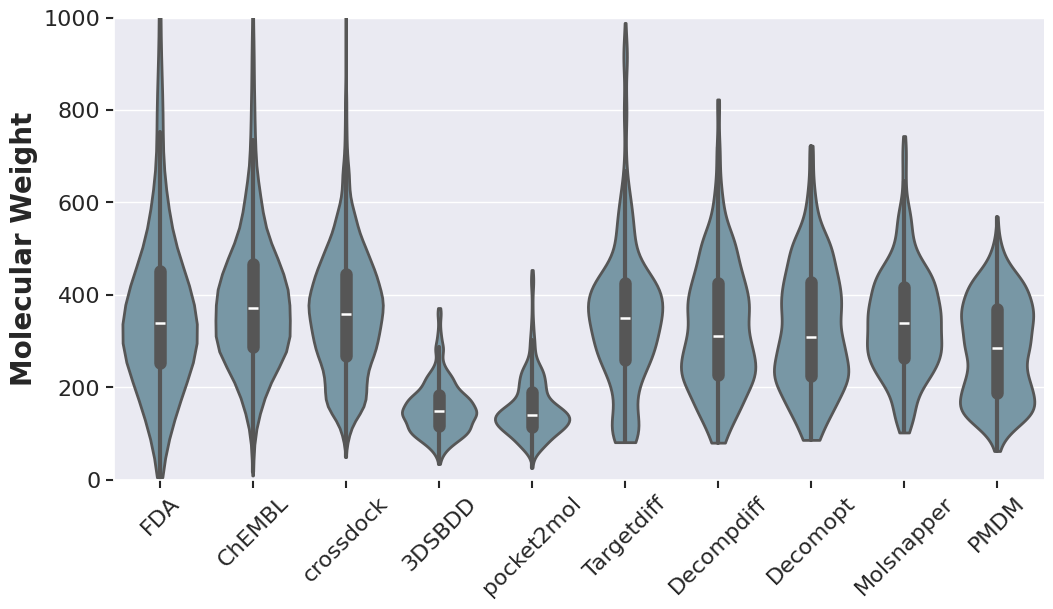

Running Tukey HSD test...
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1     group2    meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------
    3DSBDD     ChEMBL  238.9143    0.0  224.5655  253.2631   True
    3DSBDD   Decomopt  171.3573    0.0  149.8196  192.8949   True
    3DSBDD Decompdiff  173.6577    0.0    151.86  195.4553   True
    3DSBDD        FDA   241.918    0.0  225.4906  258.3453   True
    3DSBDD Molsnapper  187.8476    0.0  165.5035  210.1917   True
    3DSBDD       PMDM  127.0449    0.0  106.1723  147.9174   True
    3DSBDD Targetdiff  195.6465    0.0  174.6631  216.6299   True
    3DSBDD  crossdock  205.9015    0.0  191.9519  219.8511   True
    3DSBDD pocket2mol    0.9117    1.0  -19.2464   21.0698  False
    ChEMBL   Decomopt  -67.5571    0.0  -85.5892  -49.5249   True
    ChEMBL Decompdiff  -65.2567    0.0  -83.5986  -46.9148   True
    ChEMBL        FDA    3.0036 0.9981   -8.4482  

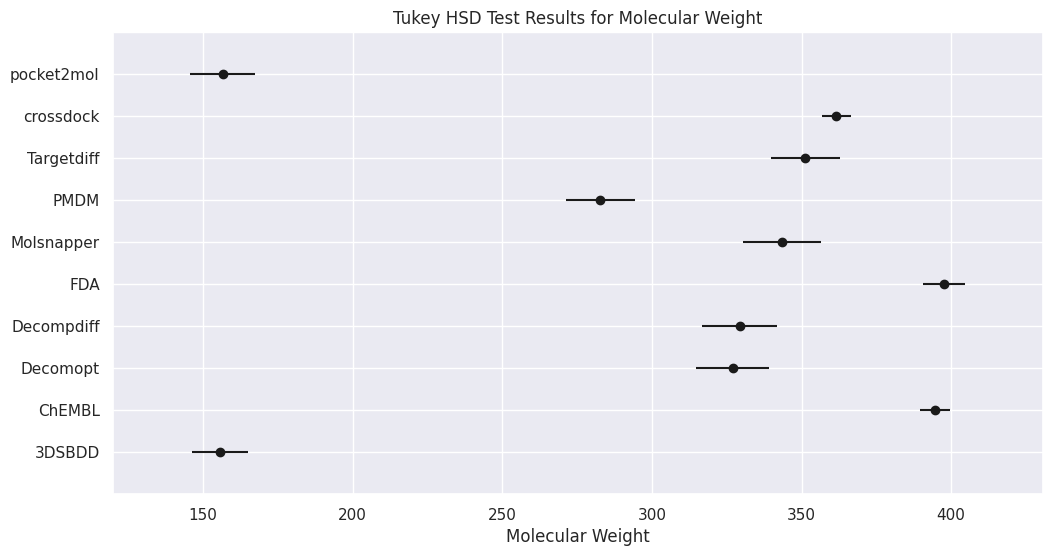

In [22]:
def calculate_molecular_weights(smiles_list):
    """Calculate molecular weights for a list of SMILES strings."""
    molecular_weights = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mw = Descriptors.MolWt(mol)
            molecular_weights.append(mw)
    return molecular_weights

def plot_molecular_weight_violinplot_and_tukey(dfs, labels):
    """Plot the distribution of molecular weights and run Tukey HSD."""
    # Prepare data for violin plot and Tukey HSD
    data = []
    for df, label in zip(dfs, labels):
        molecular_weights = calculate_molecular_weights(df['SMILES'].tolist())
        data.extend([(label, mw) for mw in molecular_weights])

    # Create a DataFrame for plotting and statistical testing
    plot_df = pd.DataFrame(data, columns=["Dataset", "Molecular Weight"])
    
    # Plotting the violin plot
    plt.figure(figsize=(12, 6))
    single_color = '#719AAC'
    sns.violinplot(x="Dataset", y="Molecular Weight", data=plot_df, palette=[single_color] * len(labels), cut=0, linewidth=2)
    # plt.title("Molecular Weight Distributions", fontsize=18, fontweight="bold")
    # plt.xlabel("Dataset", fontsize=20, fontweight="bold")
    plt.xlabel("")
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel("Molecular Weight", fontsize=20, fontweight="bold")
    plt.ylim(0, 1000)
    # Remove the top and right borders
    sns.despine(top=True, right=True, left=False, bottom=False)

    # Adjust the tick parameters for smaller ticks
    plt.tick_params(axis='both', which='major', direction='out', length=6, width=1.5)
    plt.gca().tick_params(bottom=True, left=True)
    output_path = "/home/yang2531/Desktop/Figures/molecular_weights_distribution_v2.png"  # Replace with your desired path
    plt.savefig(output_path, dpi=600, bbox_inches="tight")
    plt.show()

    # Tukey HSD test
    print("Running Tukey HSD test...")
    tukey_result = pairwise_tukeyhsd(
        endog=plot_df["Molecular Weight"],  # The numeric values
        groups=plot_df["Dataset"],          # The categorical group labels
        alpha=0.05                          # Significance level
    )
    print(tukey_result)

    # Optional: Visualize the Tukey HSD test result
    tukey_result.plot_simultaneous(figsize=(12, 6))
    plt.title("Tukey HSD Test Results for Molecular Weight")
    plt.xlabel("Molecular Weight")
    plt.show()

# Example usage with a list of DataFrames and their labels
dfs = [df_fda, df_ChEMBL, df_crossdock, df_3DSBDD, df_p2m, df_targetdiff, df_decompdiff, df_decompopt, df_molsnapper, df_pmdm]  # Replace with your actual DataFrames
labels = ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomopt", "Molsnapper", "PMDM"]  # Replace with your actual labels

plot_molecular_weight_violinplot_and_tukey(dfs, labels)

[14:20:08] WARNING: not removing hydrogen atom without neighbors
[14:20:08] WARNING: not removing hydrogen atom without neighbors
[14:20:08] WARNING: not removing hydrogen atom without neighbors
[14:20:08] WARNING: not removing hydrogen atom without neighbors
[14:20:09] WARNING: not removing hydrogen atom without neighbors


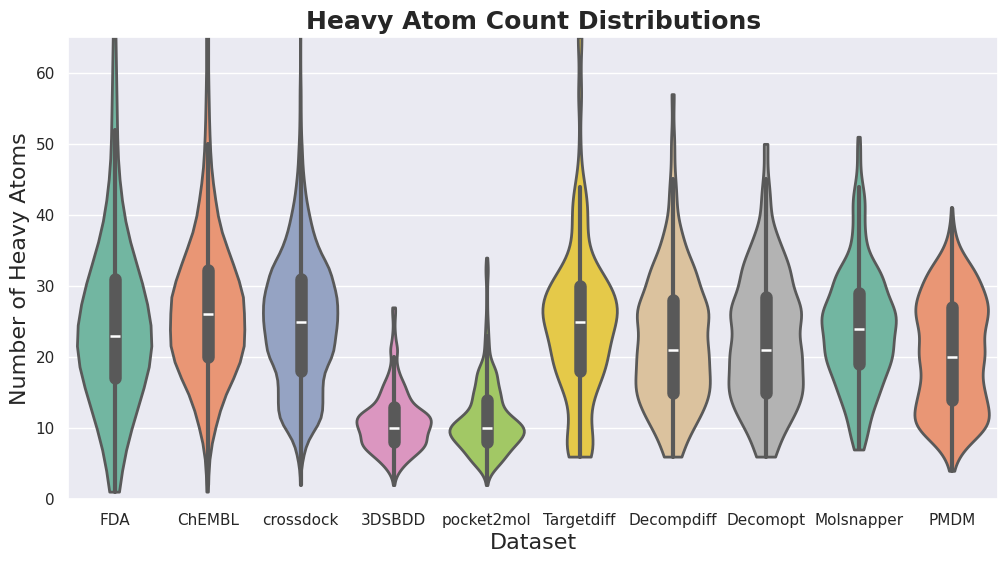

In [23]:
def calculate_heavy_atom_counts(smiles_list):
    """Calculate heavy atom counts for a list of SMILES strings."""
    heavy_atom_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            heavy_atom_count = mol.GetNumHeavyAtoms()
            heavy_atom_counts.append(heavy_atom_count)
    return heavy_atom_counts

def plot_HA_violinplot(dfs, labels):
    """Plot the distribution of heavy atom counts for multiple DataFrames as a violin plot."""
    # Prepare data for violin plot
    data = []
    for df, label in zip(dfs, labels):
        heavy_atom_counts = calculate_heavy_atom_counts(df['SMILES'].tolist())
        data.extend([(label, count) for count in heavy_atom_counts])

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(data, columns=["Dataset", "Heavy Atom Count"])
    
    # Plotting the violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(x="Dataset", y="Heavy Atom Count", data=plot_df, palette="Set2", cut=0, linewidth=2)
    
    # Customizing the plot
    plt.title("Heavy Atom Count Distributions", fontsize=18, fontweight="bold")
    plt.xlabel("Dataset", fontsize=16)
    plt.ylabel("Number of Heavy Atoms", fontsize=16)
    plt.ylim(0, 65)  # Set y-axis limit as per your requirement

    plt.show()
    
# Example usage with a list of DataFrames and their labels
dfs = [df_fda, df_ChEMBL, df_crossdock, df_3DSBDD, df_p2m, df_targetdiff, df_decompdiff, df_decompopt, df_molsnapper, df_pmdm]  # Replace with your actual DataFrames
labels = ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomopt", "Molsnapper", "PMDM"]  # Replace with your actual labels

plot_HA_violinplot(dfs, labels)

[14:20:12] WARNING: not removing hydrogen atom without neighbors
[14:20:13] WARNING: not removing hydrogen atom without neighbors
[14:20:13] WARNING: not removing hydrogen atom without neighbors
[14:20:13] WARNING: not removing hydrogen atom without neighbors
[14:20:14] WARNING: not removing hydrogen atom without neighbors


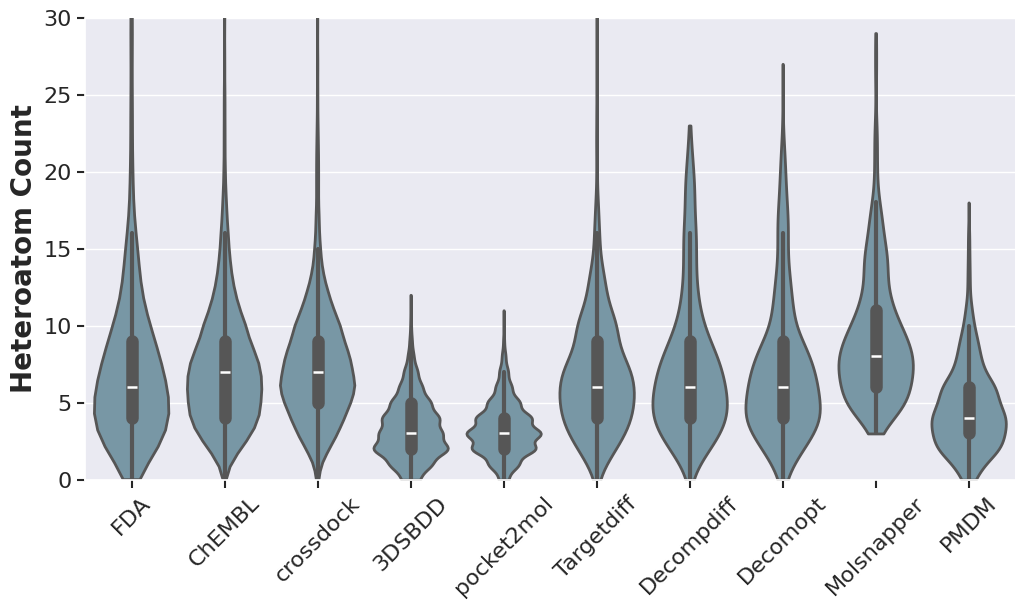

Running Tukey HSD test...
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
    3DSBDD     ChEMBL   4.0779    0.0  3.6906  4.4653   True
    3DSBDD   Decomopt   3.8415    0.0  3.2602  4.4229   True
    3DSBDD Decompdiff   4.1461    0.0  3.5577  4.7344   True
    3DSBDD        FDA   4.4468    0.0  4.0034  4.8902   True
    3DSBDD Molsnapper   5.9347    0.0  5.3316  6.5379   True
    3DSBDD       PMDM   1.3583    0.0  0.7949  1.9217   True
    3DSBDD Targetdiff   3.5639    0.0  2.9975  4.1303   True
    3DSBDD  crossdock   4.1986    0.0   3.822  4.5751   True
    3DSBDD pocket2mol   -0.043    1.0 -0.5871  0.5011  False
    ChEMBL   Decomopt  -0.2364 0.8775 -0.7232  0.2503  False
    ChEMBL Decompdiff   0.0681    1.0  -0.427  0.5632  False
    ChEMBL        FDA   0.3688 0.0062  0.0597   0.678   True
    ChEMBL Molsnapper   1.8568    0.0  1.3442  2.3693   Tru

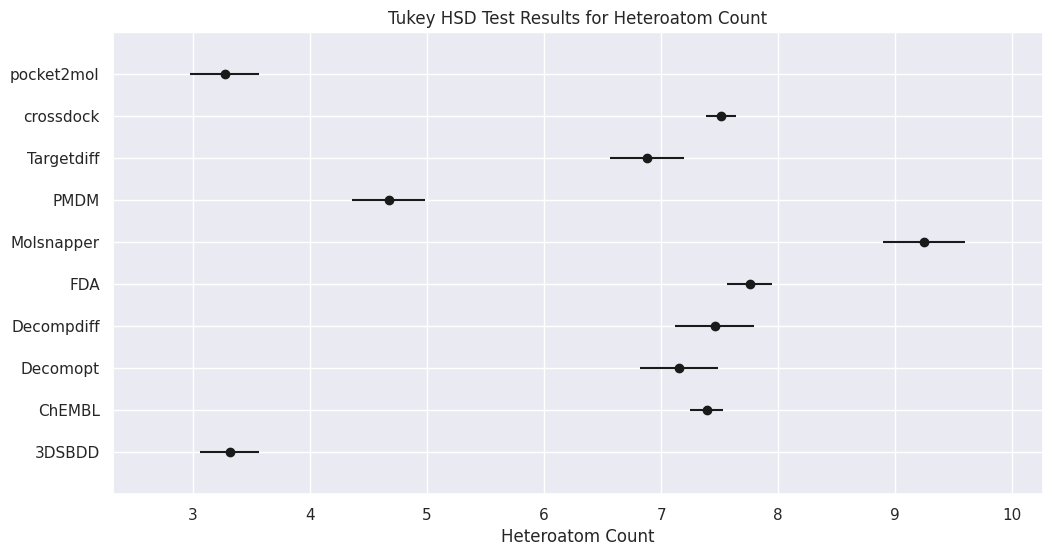

In [24]:
def calculate_heteroatom_counts(smiles_list):
    """Calculate the number of heteroatoms for each SMILES string in the list."""
    heteroatom_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Count atoms that are not C or H
            heteroatom_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() not in {1, 6})
            heteroatom_counts.append(heteroatom_count)
    return heteroatom_counts

def plot_HeteroA_violinplot_and_tukey(dfs, labels):
    """Plot the distribution of heteroatom counts and run Tukey HSD."""
    # Prepare data for violin plot and Tukey HSD
    data = []
    for df, label in zip(dfs, labels):
        heteroatom_counts = calculate_heteroatom_counts(df['SMILES'].tolist())
        data.extend([(label, count) for count in heteroatom_counts])

    # Create a DataFrame for plotting and statistical testing
    plot_df = pd.DataFrame(data, columns=["Dataset", "Heteroatom Count"])
    
    # Plotting the violin plot
    plt.figure(figsize=(12, 6))
    single_color = '#719AAC'
    sns.violinplot(x="Dataset", y="Heteroatom Count", data=plot_df, palette=[single_color] * len(label), cut=0, linewidth=2)
    # plt.title("Molecular Weight Distributions", fontsize=18, fontweight="bold")
    # plt.xlabel("Dataset", fontsize=20, fontweight="bold")
    plt.xlabel("")
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel("Heteroatom Count", fontsize=20, fontweight="bold")
    plt.ylim(0, 30)
    # Remove the top and right borders
    sns.despine(top=True, right=True, left=False, bottom=False)

    # Adjust the tick parameters for smaller ticks
    plt.tick_params(axis='both', which='major', direction='out', length=6, width=1.5)
    plt.gca().tick_params(bottom=True, left=True)
    
    output_path = "/home/yang2531/Desktop/Figures/Heteroatom_Count_distribution_v2.png"  # Replace with your desired path
    plt.savefig(output_path, dpi=600, bbox_inches="tight")
    plt.show()

    # Tukey HSD test
    print("Running Tukey HSD test...")
    tukey_result = pairwise_tukeyhsd(
        endog=plot_df["Heteroatom Count"],  # The numeric values
        groups=plot_df["Dataset"],          # The categorical group labels
        alpha=0.05                          # Significance level
    )
    print(tukey_result)

    # Optional: Visualize the Tukey HSD test result
    tukey_result.plot_simultaneous(figsize=(12, 6))
    plt.title("Tukey HSD Test Results for Heteroatom Count")
    plt.xlabel("Heteroatom Count")
    plt.show()

# Example usage with a list of DataFrames and their labels
dfs = [df_fda, df_ChEMBL, df_crossdock, df_3DSBDD, df_p2m, df_targetdiff, df_decompdiff, df_decompopt, df_molsnapper, df_pmdm]  # Replace with your actual DataFrames
labels = ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomopt", "Molsnapper", "PMDM"]  # Replace with your actual labels

plot_HeteroA_violinplot_and_tukey(dfs, labels)

[14:20:21] WARNING: not removing hydrogen atom without neighbors
[14:20:21] WARNING: not removing hydrogen atom without neighbors
[14:20:21] WARNING: not removing hydrogen atom without neighbors
[14:20:21] WARNING: not removing hydrogen atom without neighbors
[14:20:22] WARNING: not removing hydrogen atom without neighbors


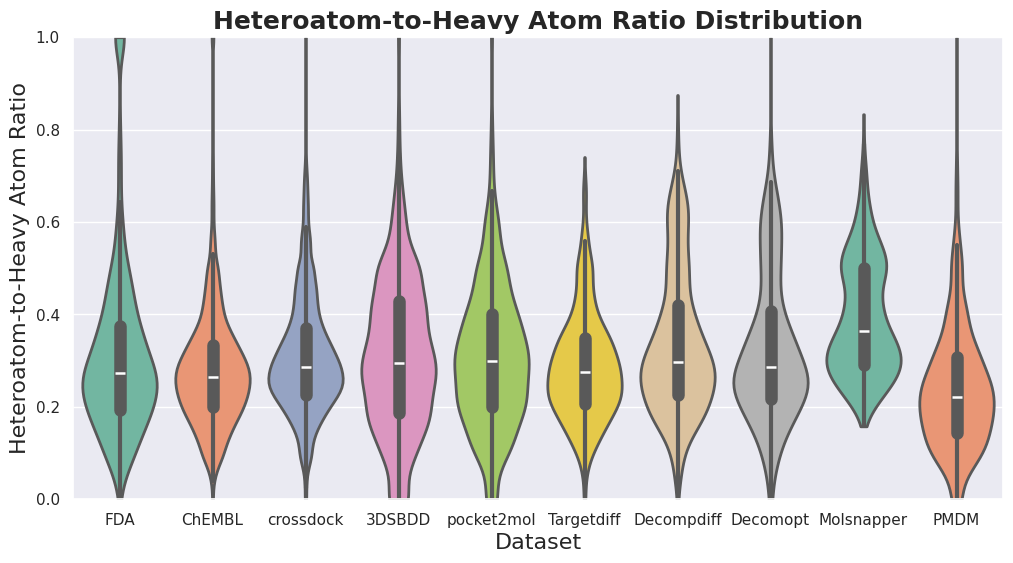

In [25]:
def calculate_heteroatom_ratio(smiles_list):
    """Calculate the ratio of heteroatoms to heavy atoms for each molecule in the SMILES list."""
    heteroatom_ratios = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Count heavy atoms (all atoms except hydrogen)
            heavy_atom_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() != 1)
            # Count heteroatoms (atoms other than C and H)
            heteroatom_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() not in {1, 6})
            # Calculate ratio if heavy_atom_count is non-zero
            if heavy_atom_count > 0:
                ratio = heteroatom_count / heavy_atom_count
                heteroatom_ratios.append(ratio)
    return heteroatom_ratios

def plot_HeteroA_HA_violinplot(dfs, labels):
    """Plot the distribution of heteroatom-to-heavy atom ratios for multiple DataFrames as a violin plot."""
    # Prepare data for violin plot
    data = []
    for df, label in zip(dfs, labels):
        ratios = calculate_heteroatom_ratio(df['SMILES'].tolist())
        data.extend([(label, ratio) for ratio in ratios])

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(data, columns=["Dataset", "Heteroatom/Heavy Atom Ratio"])
    
    # Plotting the violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(x="Dataset", y="Heteroatom/Heavy Atom Ratio", data=plot_df, palette="Set2", cut=0, linewidth=2)
    
    # Customizing the plot
    plt.title("Heteroatom-to-Heavy Atom Ratio Distribution", fontsize=18, fontweight="bold")
    plt.xlabel("Dataset", fontsize=16)
    plt.ylabel("Heteroatom-to-Heavy Atom Ratio", fontsize=16)
    plt.ylim(0, 1)  # Set y-axis limit as per your requirement

    plt.show()

# Example usage with a list of DataFrames and their labels
dfs = [df_fda, df_ChEMBL, df_crossdock, df_3DSBDD, df_p2m, df_targetdiff, df_decompdiff, df_decompopt, df_molsnapper, df_pmdm]  # Replace with your actual DataFrames
labels = ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomopt", "Molsnapper", "PMDM"] # Replace with your actual labels

plot_HeteroA_HA_violinplot(dfs, labels)

[14:20:28] WARNING: not removing hydrogen atom without neighbors
[14:20:29] WARNING: not removing hydrogen atom without neighbors
[14:20:29] WARNING: not removing hydrogen atom without neighbors
[14:20:29] WARNING: not removing hydrogen atom without neighbors
[14:20:30] WARNING: not removing hydrogen atom without neighbors


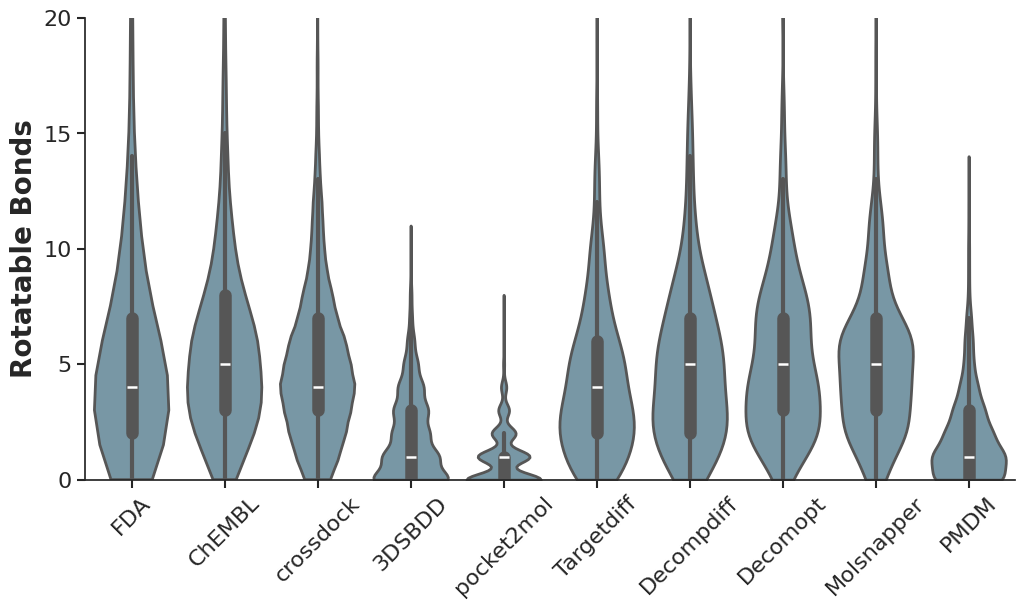

Running Tukey HSD test...
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
    3DSBDD     ChEMBL   4.0007    0.0  3.6158  4.3855   True
    3DSBDD   Decomopt   3.4194    0.0  2.8418  3.9971   True
    3DSBDD Decompdiff   3.2351    0.0  2.6505  3.8197   True
    3DSBDD        FDA   4.1792    0.0  3.7386  4.6198   True
    3DSBDD Molsnapper   3.2459    0.0  2.6466  3.8452   True
    3DSBDD       PMDM   0.0229    1.0 -0.5369  0.5827  False
    3DSBDD Targetdiff   2.3272    0.0  1.7645    2.89   True
    3DSBDD  crossdock   3.0588    0.0  2.6846  3.4329   True
    3DSBDD pocket2mol  -0.9415    0.0 -1.4821 -0.4008   True
    ChEMBL   Decomopt  -0.5812 0.0056 -1.0649 -0.0976   True
    ChEMBL Decompdiff  -0.7656    0.0 -1.2575 -0.2737   True
    ChEMBL        FDA   0.1785 0.7101 -0.1286  0.4857  False
    ChEMBL Molsnapper  -0.7548 0.0001 -1.2641 -0.2455   Tru

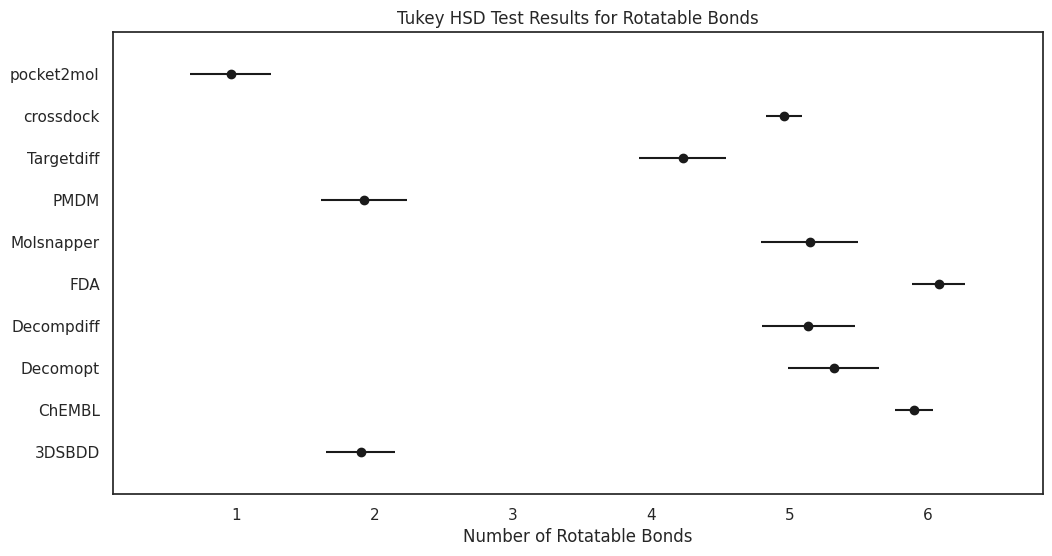

In [26]:
def calculate_rotatable_bonds(smiles_list):
    """Calculate the number of rotatable bonds for each molecule in the SMILES list."""
    rotatable_bonds_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Calculate the number of rotatable bonds
            rotatable_bonds = Descriptors.NumRotatableBonds(mol)
            rotatable_bonds_counts.append(rotatable_bonds)
    return rotatable_bonds_counts

def plot_rotatable_bonds_violinplot_and_tukey(dfs, labels):
    """Plot the distribution of rotatable bonds and run Tukey HSD."""
    # Prepare data for violin plot and Tukey HSD
    data = []
    for df, label in zip(dfs, labels):
        rotatable_bonds = calculate_rotatable_bonds(df['SMILES'].tolist())
        data.extend([(label, rb) for rb in rotatable_bonds])
    

    # Create a DataFrame for plotting and statistical testing
    plot_df = pd.DataFrame(data, columns=["Dataset", "Rotatable Bonds"])
    
    sns.set_theme(style="white")
    # Plotting the violin plot
    plt.figure(figsize=(12, 6))
    single_color = '#719AAC'
    sns.violinplot(x="Dataset", y="Rotatable Bonds", data=plot_df, palette=[single_color]*len(label), cut=0, linewidth=2)
    # plt.title("Molecular Weight Distributions", fontsize=18, fontweight="bold")
    # plt.xlabel("Dataset", fontsize=20, fontweight="bold")
    plt.xlabel("")
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel("Rotatable Bonds", fontsize=20, fontweight="bold")
    plt.ylim(0, 20)
    plt.yticks([0, 5, 10, 15, 20])
    # Remove the top and right borders
    sns.despine(top=True, right=True, left=False, bottom=False)

    # Adjust the tick parameters for smaller ticks
    plt.tick_params(axis='both', which='major', direction='out', length=6, width=1.5)
    plt.gca().tick_params(bottom=True, left=True)
    
    output_path = "/home/yang2531/Desktop/Figures/rotatable_bond_distribution_v2.png"  # Replace with your desired path
    plt.savefig(output_path, dpi=600, bbox_inches="tight")
    plt.show()

    # Tukey HSD test
    print("Running Tukey HSD test...")
    tukey_result = pairwise_tukeyhsd(
        endog=plot_df["Rotatable Bonds"],  # The numeric values
        groups=plot_df["Dataset"],         # The categorical group labels
        alpha=0.05                         # Significance level
    )
    print(tukey_result)

    # Optional: Visualize the Tukey HSD test result
    tukey_result.plot_simultaneous(figsize=(12, 6))
    plt.title("Tukey HSD Test Results for Rotatable Bonds")
    plt.xlabel("Number of Rotatable Bonds")
    plt.show()

# Example usage with a list of DataFrames and their labels
dfs = [df_fda, df_ChEMBL, df_crossdock, df_3DSBDD, df_p2m, df_targetdiff, df_decompdiff, df_decompopt, df_molsnapper, df_pmdm]  # Replace with your actual DataFrames
labels = ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomopt", "Molsnapper", "PMDM"]  # Replace with your actual labels

plot_rotatable_bonds_violinplot_and_tukey(dfs, labels)

[14:20:38] WARNING: not removing hydrogen atom without neighbors
[14:20:38] WARNING: not removing hydrogen atom without neighbors
[14:20:38] WARNING: not removing hydrogen atom without neighbors
[14:20:38] WARNING: not removing hydrogen atom without neighbors
[14:20:39] WARNING: not removing hydrogen atom without neighbors


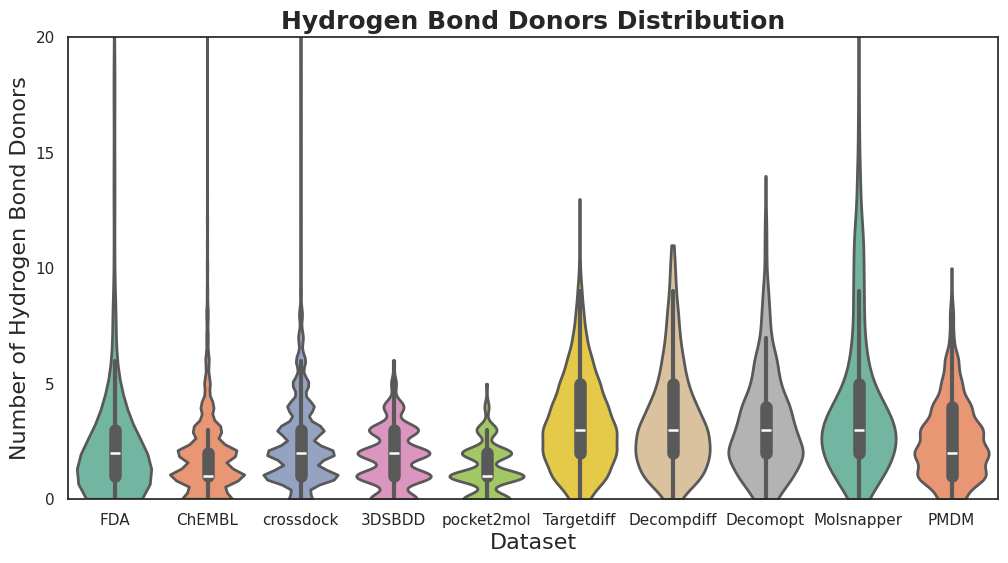

In [27]:
def calculate_hbond_donors(smiles_list):
    """Calculate the number of hydrogen bond donors for each molecule in the SMILES list."""
    hbond_donor_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Calculate the number of hydrogen bond donors
            hbond_donors = Descriptors.NumHDonors(mol)
            hbond_donor_counts.append(hbond_donors)
    return hbond_donor_counts

def plot_hbond_donors_violinplot(dfs, labels):
    """Plot the distribution of hydrogen bond donors for multiple DataFrames as a violin plot."""
    # Prepare data for violin plot
    data = []
    for df, label in zip(dfs, labels):
        hbond_donors = calculate_hbond_donors(df['SMILES'].tolist())
        data.extend([(label, hbd) for hbd in hbond_donors])

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(data, columns=["Dataset", "Hydrogen Bond Donors"])
    
    # Plotting the violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(x="Dataset", y="Hydrogen Bond Donors", data=plot_df, palette="Set2", cut=0, linewidth=2)
    
    # Customizing the plot
    plt.title("Hydrogen Bond Donors Distribution", fontsize=18, fontweight="bold")
    plt.xlabel("Dataset", fontsize=16)
    plt.ylabel("Number of Hydrogen Bond Donors", fontsize=16)
    plt.ylim(0, 20)  # Set y-axis limit as needed
    plt.yticks([0, 5, 10, 15, 20])
    plt.show()

# Example usage with a list of DataFrames and their labels
dfs = [df_fda, df_ChEMBL, df_crossdock, df_3DSBDD, df_p2m, df_targetdiff, df_decompdiff, df_decompopt, df_molsnapper, df_pmdm]  # Replace with your actual DataFrames
labels = ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomopt", "Molsnapper", "PMDM"]  # Replace with your actual labels

plot_hbond_donors_violinplot(dfs, labels)

[14:20:43] WARNING: not removing hydrogen atom without neighbors
[14:20:44] WARNING: not removing hydrogen atom without neighbors
[14:20:44] WARNING: not removing hydrogen atom without neighbors
[14:20:44] WARNING: not removing hydrogen atom without neighbors
[14:20:44] WARNING: not removing hydrogen atom without neighbors


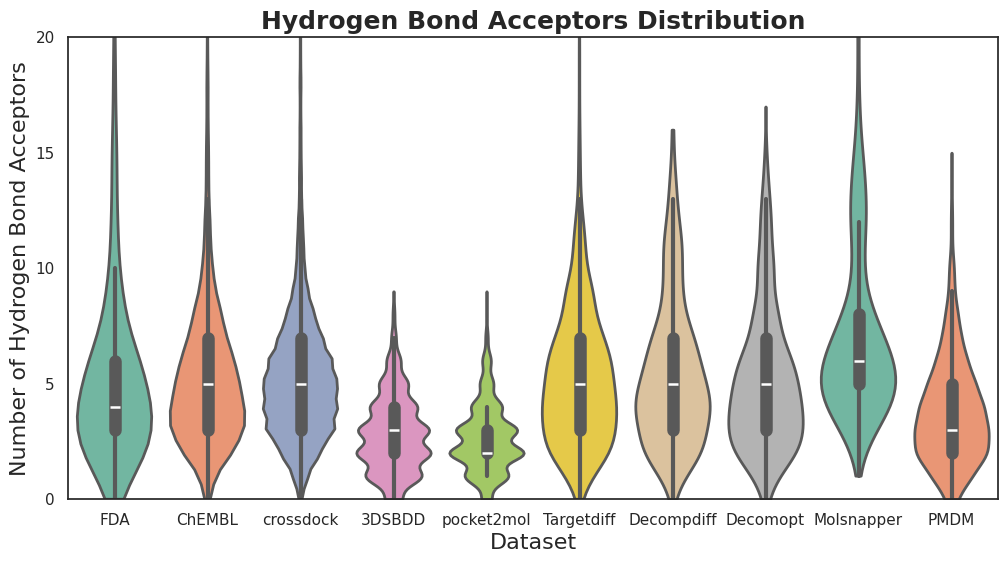

In [28]:
def calculate_hbond_acceptors(smiles_list):
    """Calculate the number of hydrogen bond acceptors for each molecule in the SMILES list."""
    hbond_acceptor_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Calculate the number of hydrogen bond acceptors
            hbond_acceptors = Descriptors.NumHAcceptors(mol)
            hbond_acceptor_counts.append(hbond_acceptors)
    return hbond_acceptor_counts

def plot_hbond_acceptors_violinplot(dfs, labels):
    """Plot the distribution of hydrogen bond acceptors for multiple DataFrames as a violin plot."""
    # Prepare data for violin plot
    data = []
    for df, label in zip(dfs, labels):
        hbond_acceptors = calculate_hbond_acceptors(df['SMILES'].tolist())
        data.extend([(label, hba) for hba in hbond_acceptors])

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(data, columns=["Dataset", "Hydrogen Bond Acceptors"])
    
    # Plotting the violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(x="Dataset", y="Hydrogen Bond Acceptors", data=plot_df, palette="Set2", cut=0, linewidth=2)
    
    # Customizing the plot
    plt.title("Hydrogen Bond Acceptors Distribution", fontsize=18, fontweight="bold")
    plt.xlabel("Dataset", fontsize=16)
    plt.ylabel("Number of Hydrogen Bond Acceptors", fontsize=16)
    plt.ylim(0, 20)  # Adjust y-axis limit as needed
    plt.yticks([0, 5, 10, 15, 20])
    plt.show()

# Example usage with a list of DataFrames and their labels
dfs = [df_fda, df_ChEMBL, df_crossdock, df_3DSBDD, df_p2m, df_targetdiff, df_decompdiff, df_decompopt, df_molsnapper, df_pmdm]  # Replace with your actual DataFrames
labels = ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomopt", "Molsnapper", "PMDM"]  # Replace with your actual labels

plot_hbond_acceptors_violinplot(dfs, labels)

[14:20:49] WARNING: not removing hydrogen atom without neighbors
[14:20:49] WARNING: not removing hydrogen atom without neighbors
[14:20:49] WARNING: not removing hydrogen atom without neighbors
[14:20:49] WARNING: not removing hydrogen atom without neighbors
[14:20:50] WARNING: not removing hydrogen atom without neighbors


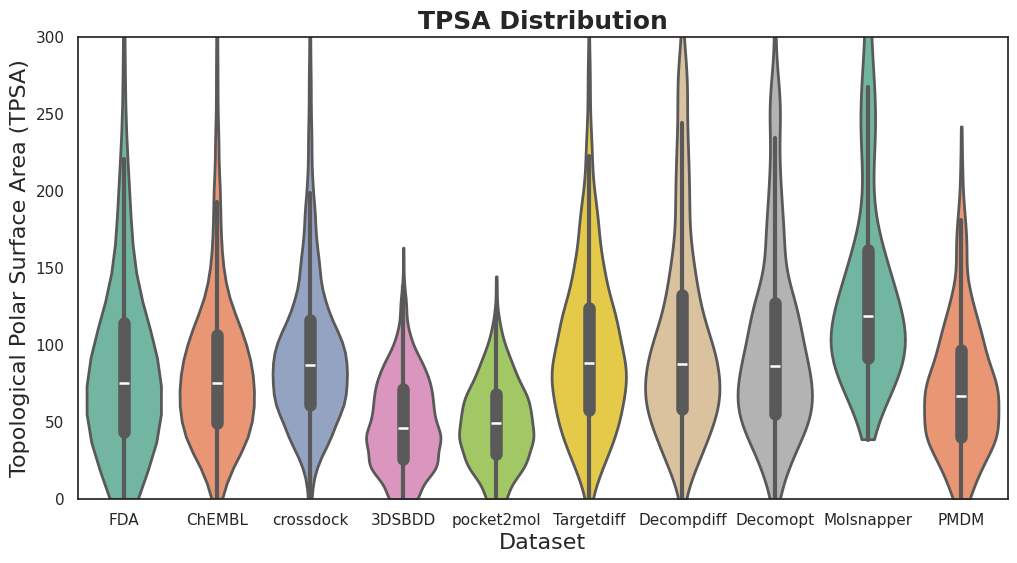

In [29]:
def calculate_tpsa(smiles_list):
    """Calculate the TPSA for each molecule in the SMILES list."""
    tpsa_values = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Calculate TPSA
            tpsa = Descriptors.TPSA(mol)
            tpsa_values.append(tpsa)
    return tpsa_values

def plot_tpsa_violinplot(dfs, labels):
    """Plot the distribution of TPSA for multiple DataFrames as a violin plot."""
    # Prepare data for violin plot
    data = []
    for df, label in zip(dfs, labels):
        tpsa_values = calculate_tpsa(df['SMILES'].tolist())
        data.extend([(label, tpsa) for tpsa in tpsa_values])

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(data, columns=["Dataset", "TPSA"])
    
    # Plotting the violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(x="Dataset", y="TPSA", data=plot_df, palette="Set2", cut=0, linewidth=2)
    
    # Customizing the plot
    plt.title("TPSA Distribution", fontsize=18, fontweight="bold")
    plt.xlabel("Dataset", fontsize=16)
    plt.ylabel("Topological Polar Surface Area (TPSA)", fontsize=16)
    plt.ylim(0, 300)  # Adjust y-axis limit as needed

    plt.show()

# Example usage with a list of DataFrames and their labels
dfs = [df_fda, df_ChEMBL, df_crossdock, df_3DSBDD, df_p2m, df_targetdiff, df_decompdiff, df_decompopt, df_molsnapper, df_pmdm]  # Replace with your actual DataFrames
labels = ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomopt", "Molsnapper", "PMDM"]  # Replace with your actual labels

plot_tpsa_violinplot(dfs, labels)

[14:20:54] WARNING: not removing hydrogen atom without neighbors
[14:20:54] WARNING: not removing hydrogen atom without neighbors
[14:20:54] WARNING: not removing hydrogen atom without neighbors
[14:20:54] WARNING: not removing hydrogen atom without neighbors
[14:20:55] WARNING: not removing hydrogen atom without neighbors


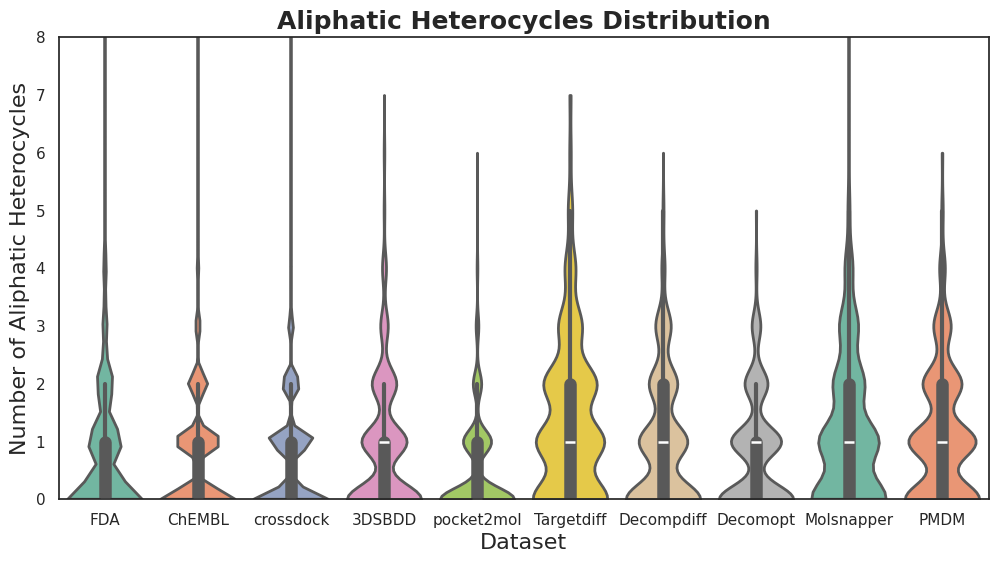

In [30]:
def calculate_aliphatic_heterocycles(smiles_list):
    """Calculate the number of aliphatic heterocycles for each molecule in the SMILES list."""
    aliphatic_heterocycle_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Calculate the number of aliphatic heterocycles
            aliphatic_heterocycles = Lipinski.NumAliphaticHeterocycles(mol)
            aliphatic_heterocycle_counts.append(aliphatic_heterocycles)
    return aliphatic_heterocycle_counts

def plot_aliphatic_heterocycles_violinplot(dfs, labels):
    """Plot the distribution of aliphatic heterocycles for multiple DataFrames as a violin plot."""
    # Prepare data for violin plot
    data = []
    for df, label in zip(dfs, labels):
        aliphatic_heterocycles = calculate_aliphatic_heterocycles(df['SMILES'].tolist())
        data.extend([(label, count) for count in aliphatic_heterocycles])

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(data, columns=["Dataset", "Aliphatic Heterocycles"])
    
    # Plotting the violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(x="Dataset", y="Aliphatic Heterocycles", data=plot_df, palette="Set2", cut=0, linewidth=2)
    
    # Customizing the plot
    plt.title("Aliphatic Heterocycles Distribution", fontsize=18, fontweight="bold")
    plt.xlabel("Dataset", fontsize=16)
    plt.ylabel("Number of Aliphatic Heterocycles", fontsize=16)
    plt.ylim(0, 8)  # Set y-axis limit as per your requirement

    plt.show()

# Example usage with a list of DataFrames and their labels
dfs = [df_fda, df_ChEMBL, df_crossdock, df_3DSBDD, df_p2m, df_targetdiff, df_decompdiff, df_decompopt, df_molsnapper, df_pmdm]  # Replace with your actual DataFrames
labels = ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomopt", "Molsnapper", "PMDM"]  # Replace with your actual labels

plot_aliphatic_heterocycles_violinplot(dfs, labels)

[14:20:59] WARNING: not removing hydrogen atom without neighbors
[14:20:59] WARNING: not removing hydrogen atom without neighbors
[14:20:59] WARNING: not removing hydrogen atom without neighbors
[14:20:59] WARNING: not removing hydrogen atom without neighbors
[14:20:59] WARNING: not removing hydrogen atom without neighbors


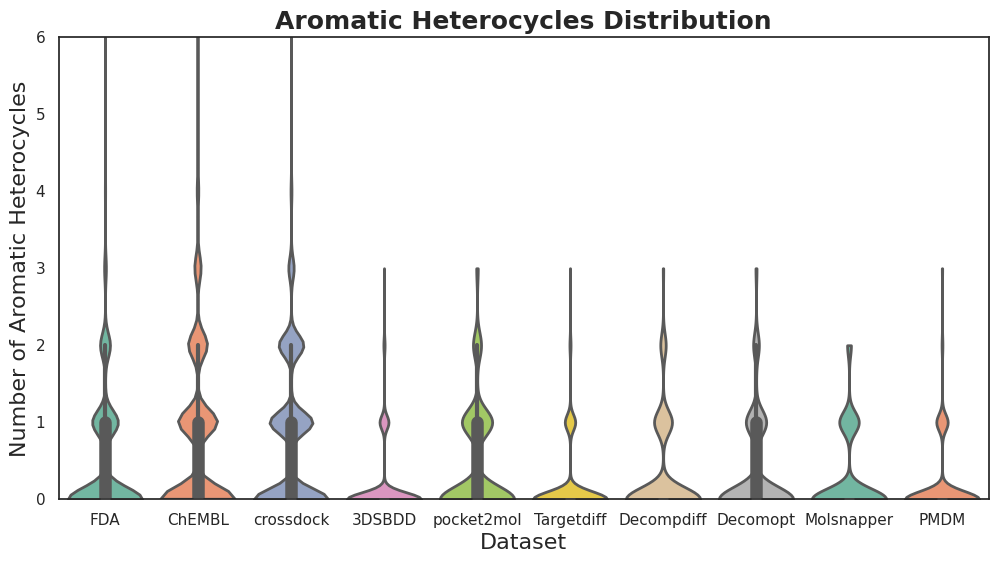

In [31]:
def calculate_aromatic_heterocycles(smiles_list):
    """Calculate the number of aromatic heterocycles for each molecule in the SMILES list."""
    aromatic_heterocycle_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Calculate the number of aromatic heterocycles
            aromatic_heterocycles = Lipinski.NumAromaticHeterocycles(mol)
            aromatic_heterocycle_counts.append(aromatic_heterocycles)
    return aromatic_heterocycle_counts

def plot_aromatic_heterocycles_violinplot(dfs, labels):
    """Plot the distribution of aromatic heterocycles for multiple DataFrames as a violin plot."""
    # Prepare data for violin plot
    data = []
    for df, label in zip(dfs, labels):
        aromatic_heterocycles = calculate_aromatic_heterocycles(df['SMILES'].tolist())
        data.extend([(label, count) for count in aromatic_heterocycles])

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(data, columns=["Dataset", "Aromatic Heterocycles"])
    
    # Plotting the violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(x="Dataset", y="Aromatic Heterocycles", data=plot_df, palette="Set2", cut=0, linewidth=2)
    
    # Customizing the plot
    plt.title("Aromatic Heterocycles Distribution", fontsize=18, fontweight="bold")
    plt.xlabel("Dataset", fontsize=16)
    plt.ylabel("Number of Aromatic Heterocycles", fontsize=16)
    plt.ylim(0, 6)  # Set y-axis limit as per your data's range

    plt.show()

# Example usage with a list of DataFrames and their labels
dfs = [df_fda, df_ChEMBL, df_crossdock, df_3DSBDD, df_p2m, df_targetdiff, df_decompdiff, df_decompopt, df_molsnapper, df_pmdm]  # Replace with your actual DataFrames
labels = ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomopt", "Molsnapper", "PMDM"]  # Replace with your actual labels

plot_aromatic_heterocycles_violinplot(dfs, labels)

[14:21:03] WARNING: not removing hydrogen atom without neighbors
[14:21:03] WARNING: not removing hydrogen atom without neighbors
[14:21:03] WARNING: not removing hydrogen atom without neighbors
[14:21:03] WARNING: not removing hydrogen atom without neighbors
[14:21:04] WARNING: not removing hydrogen atom without neighbors


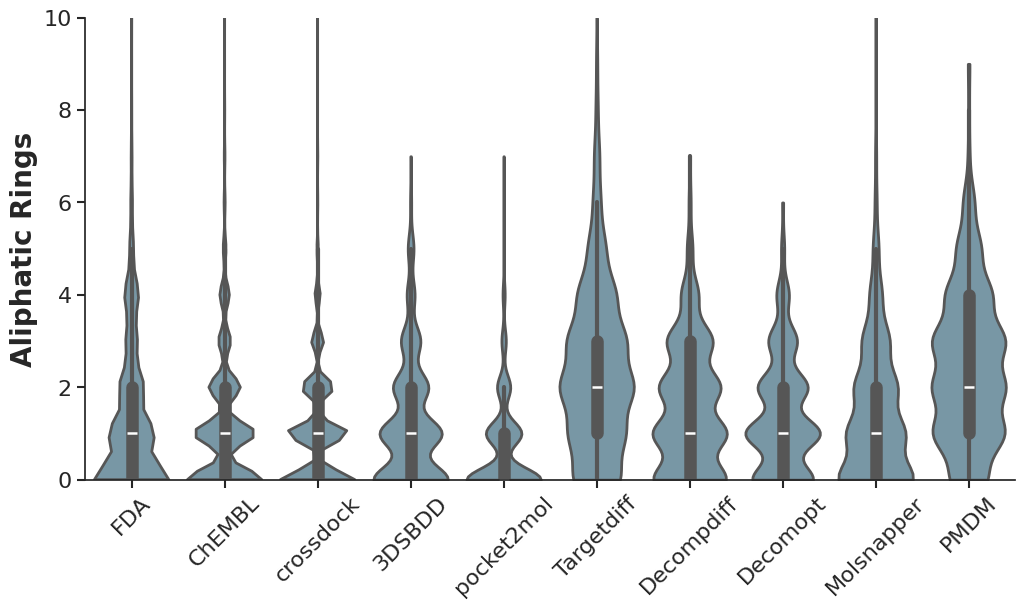

Running Tukey HSD test...
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
    3DSBDD     ChEMBL  -0.0891 0.3671 -0.2098  0.0317  False
    3DSBDD   Decomopt   0.1739  0.073 -0.0074  0.3551  False
    3DSBDD Decompdiff   0.3419    0.0  0.1584  0.5254   True
    3DSBDD        FDA   0.0292 0.9997 -0.1091  0.1674  False
    3DSBDD Molsnapper   0.2032 0.0222  0.0151  0.3913   True
    3DSBDD       PMDM    1.225    0.0  1.0493  1.4007   True
    3DSBDD Targetdiff   1.1228    0.0  0.9462  1.2994   True
    3DSBDD  crossdock  -0.2204    0.0 -0.3378  -0.103   True
    3DSBDD pocket2mol  -0.5808    0.0 -0.7504 -0.4111   True
    ChEMBL   Decomopt   0.2629    0.0  0.1112  0.4147   True
    ChEMBL Decompdiff    0.431    0.0  0.2766  0.5854   True
    ChEMBL        FDA   0.1182 0.0041  0.0218  0.2146   True
    ChEMBL Molsnapper   0.2923    0.0  0.1325  0.4521   Tru

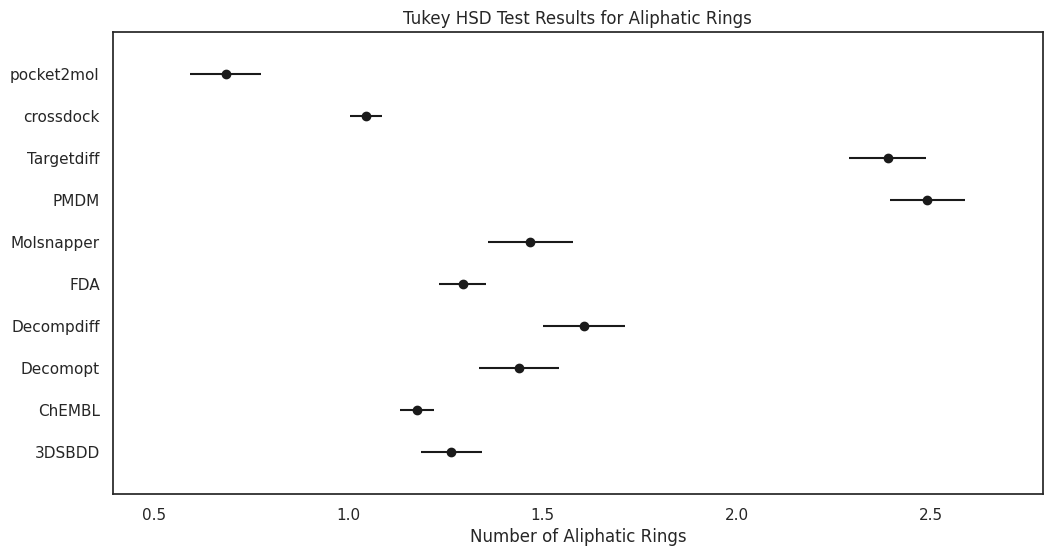

In [32]:
def calculate_aliphatic_rings(smiles_list):
    """Calculate the number of aliphatic rings for each molecule in the SMILES list."""
    aliphatic_ring_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Calculate the number of aliphatic rings
            aliphatic_rings = Lipinski.NumAliphaticRings(mol)
            aliphatic_ring_counts.append(aliphatic_rings)
    return aliphatic_ring_counts

def plot_aliphatic_rings_violinplot_and_tukey(dfs, labels):
    """Plot the distribution of aliphatic rings and run Tukey HSD."""
    # Prepare data for violin plot and Tukey HSD
    data = []
    for df, label in zip(dfs, labels):
        aliphatic_rings = calculate_aliphatic_rings(df['SMILES'].tolist())
        data.extend([(label, count) for count in aliphatic_rings])

    # Create a DataFrame for plotting and statistical testing
    plot_df = pd.DataFrame(data, columns=["Dataset", "Aliphatic Rings"])
    
    # Plotting the violin plot
    sns.set_theme(style="white")
    # Plotting the violin plot
    plt.figure(figsize=(12, 6))
    single_color = '#719AAC'
    sns.violinplot(x="Dataset", y="Aliphatic Rings", data=plot_df, palette=[single_color]*len(label), cut=0, linewidth=2)
    # plt.title("Molecular Weight Distributions", fontsize=18, fontweight="bold")
    # plt.xlabel("Dataset", fontsize=20, fontweight="bold")
    plt.xlabel("")
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel("Aliphatic Rings", fontsize=20, fontweight="bold")
    plt.ylim(0, 10)
    # plt.yticks([0, 5, 10, 15, 20])
    # Remove the top and right borders
    sns.despine(top=True, right=True, left=False, bottom=False)

    # Adjust the tick parameters for smaller ticks
    plt.tick_params(axis='both', which='major', direction='out', length=6, width=1.5)
    plt.gca().tick_params(bottom=True, left=True)
    
    output_path = "/home/yang2531/Desktop/Figures/aliphatic_rings_distribution_v2.png"  # Replace with your desired path
    plt.savefig(output_path, dpi=600, bbox_inches="tight")
    plt.show()

    # Tukey HSD test
    print("Running Tukey HSD test...")
    tukey_result = pairwise_tukeyhsd(
        endog=plot_df["Aliphatic Rings"],  # The numeric values
        groups=plot_df["Dataset"],        # The categorical group labels
        alpha=0.05                        # Significance level
    )
    print(tukey_result)

    # Optional: Visualize the Tukey HSD test result
    tukey_result.plot_simultaneous(figsize=(12, 6))
    plt.title("Tukey HSD Test Results for Aliphatic Rings")
    plt.xlabel("Number of Aliphatic Rings")
    plt.show()

# Example usage with a list of DataFrames and their labels
dfs = [df_fda, df_ChEMBL, df_crossdock, df_3DSBDD, df_p2m, df_targetdiff, df_decompdiff, df_decompopt, df_molsnapper, df_pmdm]  # Replace with your actual DataFrames
labels = ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomopt", "Molsnapper", "PMDM"]  # Replace with your actual labels

plot_aliphatic_rings_violinplot_and_tukey(dfs, labels)

[14:21:10] WARNING: not removing hydrogen atom without neighbors
[14:21:10] WARNING: not removing hydrogen atom without neighbors
[14:21:10] WARNING: not removing hydrogen atom without neighbors
[14:21:10] WARNING: not removing hydrogen atom without neighbors
[14:21:11] WARNING: not removing hydrogen atom without neighbors


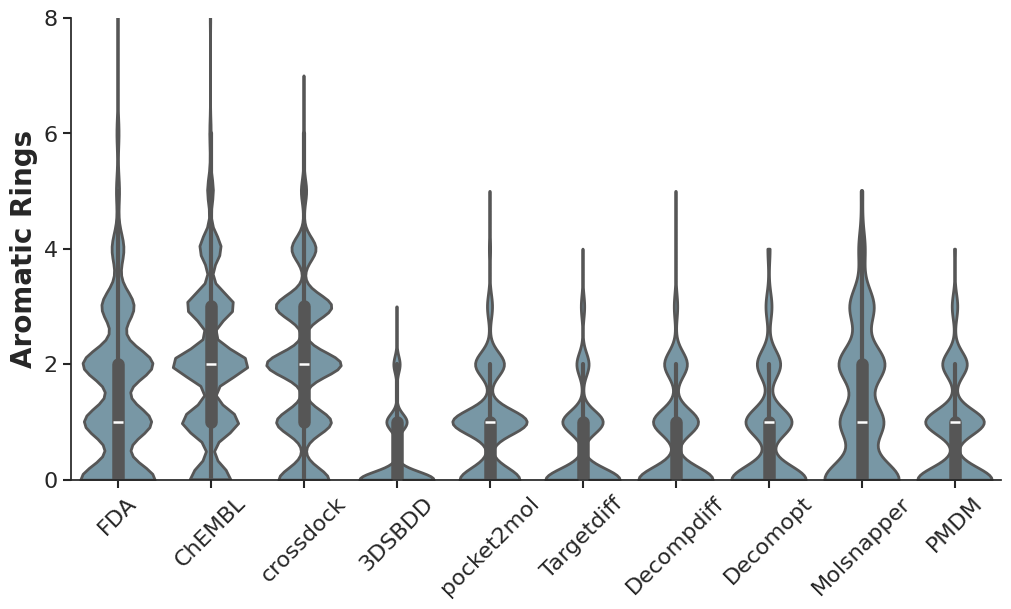

Running Tukey HSD test...
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
    3DSBDD     ChEMBL   1.5827    0.0  1.4725  1.6929   True
    3DSBDD   Decomopt   0.4485    0.0   0.283  0.6139   True
    3DSBDD Decompdiff   0.3723    0.0  0.2049  0.5398   True
    3DSBDD        FDA   1.1293    0.0  1.0031  1.2555   True
    3DSBDD Molsnapper   0.8916    0.0    0.72  1.0633   True
    3DSBDD       PMDM   0.4436    0.0  0.2833   0.604   True
    3DSBDD Targetdiff   0.2398 0.0001  0.0786   0.401   True
    3DSBDD  crossdock   1.5443    0.0  1.4372  1.6515   True
    3DSBDD pocket2mol   0.5674    0.0  0.4126  0.7223   True
    ChEMBL   Decomopt  -1.1342    0.0 -1.2728 -0.9957   True
    ChEMBL Decompdiff  -1.2104    0.0 -1.3513 -1.0695   True
    ChEMBL        FDA  -0.4534    0.0 -0.5414 -0.3655   True
    ChEMBL Molsnapper  -0.6911    0.0 -0.8369 -0.5452   Tru

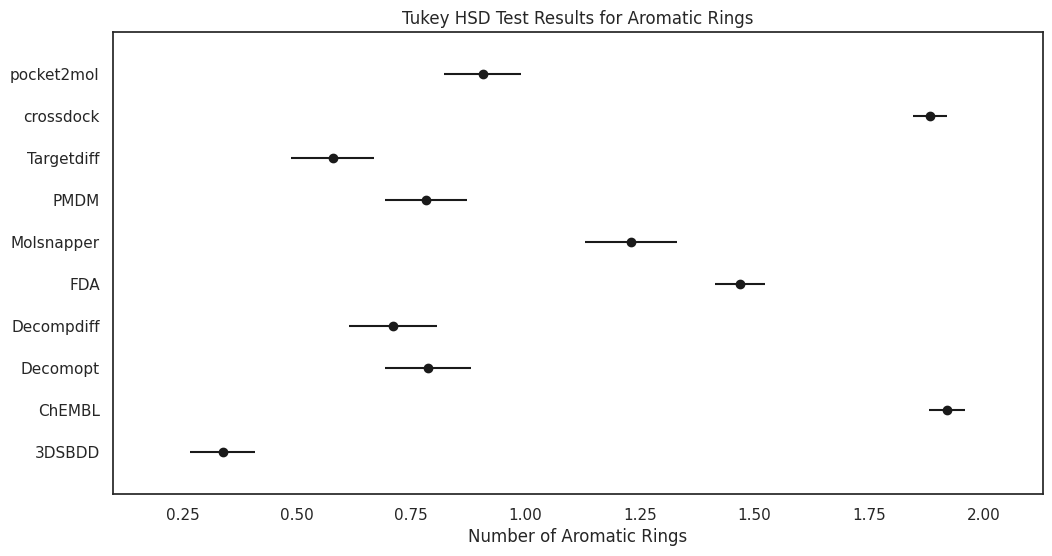

In [33]:
def calculate_aromatic_rings(smiles_list):
    """Calculate the number of aromatic rings for each molecule in the SMILES list."""
    aromatic_ring_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Calculate the number of aromatic rings
            aromatic_rings = Lipinski.NumAromaticRings(mol)
            aromatic_ring_counts.append(aromatic_rings)
    return aromatic_ring_counts

def plot_aromatic_rings_violinplot_and_tukey(dfs, labels):
    """Plot the distribution of aromatic rings and run Tukey HSD."""
    # Prepare data for violin plot and Tukey HSD
    data = []
    for df, label in zip(dfs, labels):
        aromatic_rings = calculate_aromatic_rings(df['SMILES'].tolist())
        data.extend([(label, count) for count in aromatic_rings])

    # Create a DataFrame for plotting and statistical testing
    plot_df = pd.DataFrame(data, columns=["Dataset", "Aromatic Rings"])
    
    # Plotting the violin plot
    sns.set_theme(style="white")
    # Plotting the violin plot
    plt.figure(figsize=(12, 6))
    single_color = '#719AAC'
    sns.violinplot(x="Dataset", y="Aromatic Rings", data=plot_df, palette=[single_color]*len(label), cut=0, linewidth=2)
    # plt.title("Molecular Weight Distributions", fontsize=18, fontweight="bold")
    # plt.xlabel("Dataset", fontsize=20, fontweight="bold")
    plt.xlabel("")
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel("Aromatic Rings", fontsize=20, fontweight="bold")
    plt.ylim(0, 8)
    plt.yticks([0, 2, 4, 6, 8])
    # Remove the top and right borders
    sns.despine(top=True, right=True, left=False, bottom=False)

    # Adjust the tick parameters for smaller ticks
    plt.tick_params(axis='both', which='major', direction='out', length=6, width=1.5)
    plt.gca().tick_params(bottom=True, left=True)
    
    output_path = "/home/yang2531/Desktop/Figures/aromatic_rings_distribution_v2.png"  # Replace with your desired path
    plt.savefig(output_path, dpi=600, bbox_inches="tight")
    plt.show()
    
    # Tukey HSD test
    print("Running Tukey HSD test...")
    tukey_result = pairwise_tukeyhsd(
        endog=plot_df["Aromatic Rings"],  # The numeric values
        groups=plot_df["Dataset"],        # The categorical group labels
        alpha=0.05                        # Significance level
    )
    print(tukey_result)

    # Optional: Visualize the Tukey HSD test result
    tukey_result.plot_simultaneous(figsize=(12, 6))
    plt.title("Tukey HSD Test Results for Aromatic Rings")
    plt.xlabel("Number of Aromatic Rings")
    plt.show()

# Example usage with a list of DataFrames and their labels
dfs = [df_fda, df_ChEMBL, df_crossdock, df_3DSBDD, df_p2m, df_targetdiff, df_decompdiff, df_decompopt, df_molsnapper, df_pmdm]  # Replace with your actual DataFrames
labels = ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomopt", "Molsnapper", "PMDM"]  # Replace with your actual labels

plot_aromatic_rings_violinplot_and_tukey(dfs, labels)

[14:21:17] WARNING: not removing hydrogen atom without neighbors
[14:21:17] WARNING: not removing hydrogen atom without neighbors
[14:21:17] WARNING: not removing hydrogen atom without neighbors
[14:21:17] WARNING: not removing hydrogen atom without neighbors
[14:21:18] WARNING: not removing hydrogen atom without neighbors


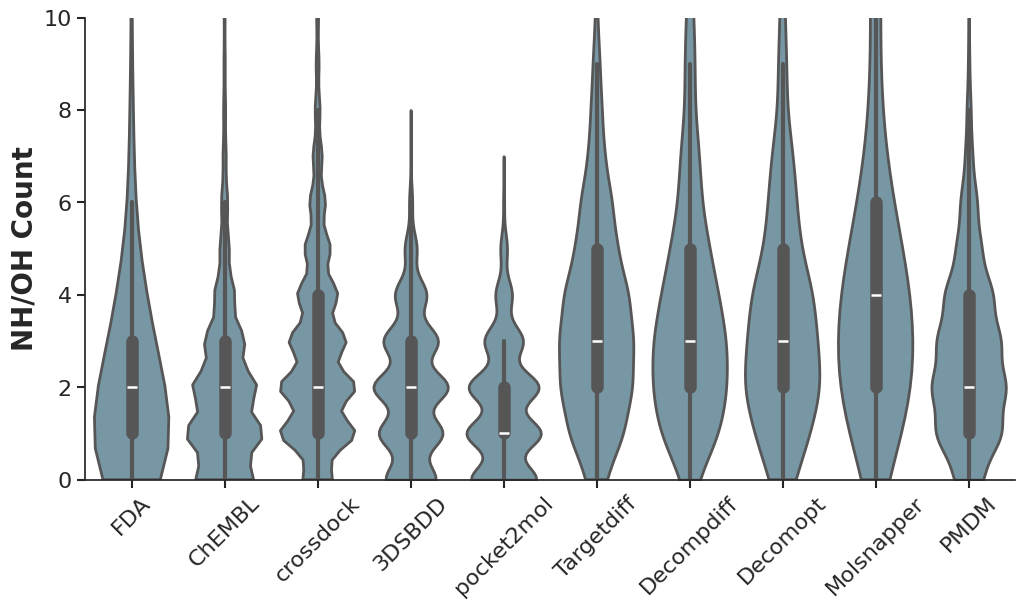

Running Tukey HSD test...
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
    3DSBDD     ChEMBL   0.0449 0.9998 -0.1796  0.2694  False
    3DSBDD   Decomopt   1.5955    0.0  1.2586  1.9324   True
    3DSBDD Decompdiff   1.6836    0.0  1.3426  2.0246   True
    3DSBDD        FDA   0.7008    0.0  0.4438  0.9578   True
    3DSBDD Molsnapper   3.4144    0.0  3.0649   3.764   True
    3DSBDD       PMDM   0.7542    0.0  0.4277  1.0807   True
    3DSBDD Targetdiff   1.4787    0.0  1.1504  1.8069   True
    3DSBDD  crossdock   0.7911    0.0  0.5729  1.0093   True
    3DSBDD pocket2mol  -0.4139 0.0014 -0.7293 -0.0986   True
    ChEMBL   Decomopt   1.5506    0.0  1.2685  1.8327   True
    ChEMBL Decompdiff   1.6387    0.0  1.3518  1.9256   True
    ChEMBL        FDA   0.6559    0.0  0.4768   0.835   True
    ChEMBL Molsnapper   3.3695    0.0  3.0725  3.6666   Tru

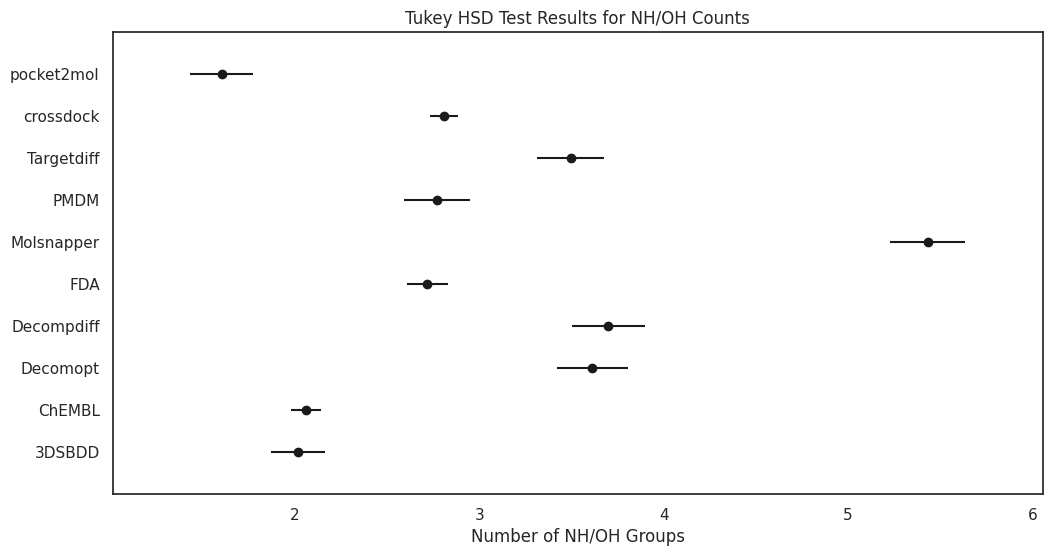

In [34]:
def calculate_nhoh_counts(smiles_list):
    """Calculate the number of NH and OH groups for each molecule in the SMILES list."""
    nhoh_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Calculate the number of NH and OH groups
            nhoh_count = Lipinski.NHOHCount(mol)
            nhoh_counts.append(nhoh_count)
    return nhoh_counts

def plot_nhoh_violinplot_and_tukey(dfs, labels):
    """Plot the distribution of NH and OH counts and run Tukey HSD."""
    # Prepare data for violin plot and Tukey HSD
    data = []
    for df, label in zip(dfs, labels):
        nhoh_counts = calculate_nhoh_counts(df['SMILES'].tolist())
        data.extend([(label, count) for count in nhoh_counts])

    # Create a DataFrame for plotting and statistical testing
    plot_df = pd.DataFrame(data, columns=["Dataset", "NH/OH Count"])
    
    # Plotting the violin plot
    sns.set_theme(style="white")
    # Plotting the violin plot
    plt.figure(figsize=(12, 6))
    single_color = '#719AAC'
    sns.violinplot(x="Dataset", y="NH/OH Count", data=plot_df, palette=[single_color]*len(label), cut=0, linewidth=2)
    # plt.title("Molecular Weight Distributions", fontsize=18, fontweight="bold")
    # plt.xlabel("Dataset", fontsize=20, fontweight="bold")
    plt.xlabel("")
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel("NH/OH Count", fontsize=20, fontweight="bold")
    plt.ylim(0, 10)
    # plt.yticks([0, 2, 4, 6, 8])
    # Remove the top and right borders
    sns.despine(top=True, right=True, left=False, bottom=False)

    # Adjust the tick parameters for smaller ticks
    plt.tick_params(axis='both', which='major', direction='out', length=6, width=1.5)
    plt.gca().tick_params(bottom=True, left=True)
    
    output_path = "/home/yang2531/Desktop/Figures/nhoh_count_distribution_v2.png"  # Replace with your desired path
    plt.savefig(output_path, dpi=600, bbox_inches="tight")
    plt.show()

    # Tukey HSD test
    print("Running Tukey HSD test...")
    tukey_result = pairwise_tukeyhsd(
        endog=plot_df["NH/OH Count"],  # The numeric values
        groups=plot_df["Dataset"],     # The categorical group labels
        alpha=0.05                     # Significance level
    )
    print(tukey_result)

    # Optional: Visualize the Tukey HSD test result
    tukey_result.plot_simultaneous(figsize=(12, 6))
    plt.title("Tukey HSD Test Results for NH/OH Counts")
    plt.xlabel("Number of NH/OH Groups")
    plt.show()

# Example usage with a list of DataFrames and their labels
dfs = [df_fda, df_ChEMBL, df_crossdock, df_3DSBDD, df_p2m, df_targetdiff, df_decompdiff, df_decompopt, df_molsnapper, df_pmdm]  # Replace with your actual DataFrames
labels = ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomopt", "Molsnapper", "PMDM"]  # Replace with your actual labels

plot_nhoh_violinplot_and_tukey(dfs, labels)

[14:21:23] WARNING: not removing hydrogen atom without neighbors
[14:21:24] WARNING: not removing hydrogen atom without neighbors
[14:21:24] WARNING: not removing hydrogen atom without neighbors
[14:21:24] WARNING: not removing hydrogen atom without neighbors
[14:21:24] WARNING: not removing hydrogen atom without neighbors


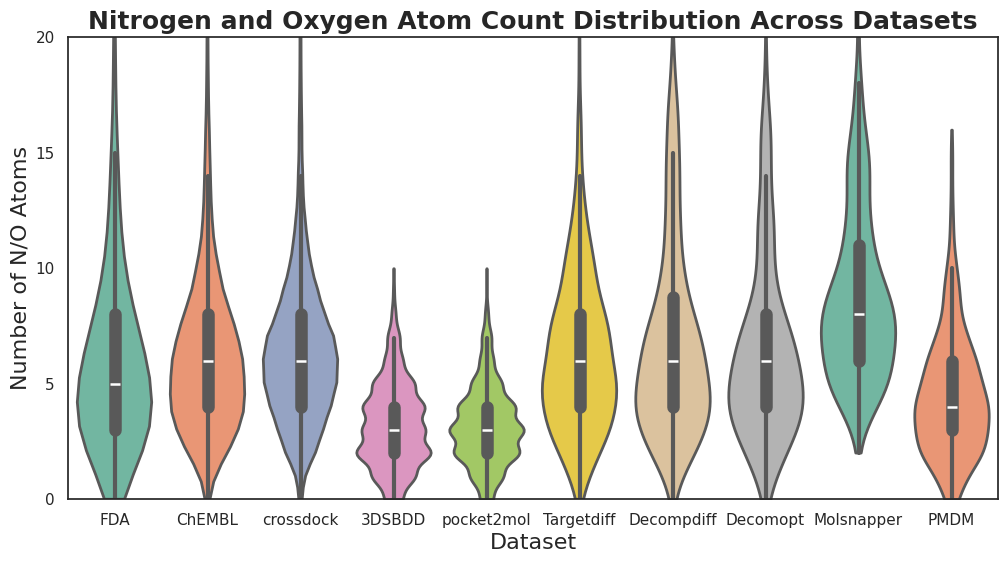

In [35]:
def calculate_no_counts(smiles_list):
    """Calculate the number of nitrogen (N) and oxygen (O) atoms for each molecule in the SMILES list."""
    no_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Calculate the number of N and O atoms
            no_count = Lipinski.NOCount(mol)
            no_counts.append(no_count)
    return no_counts

def plot_no_distribution(dfs, labels):
    """Plot the distribution of N and O counts for multiple DataFrames as a violin plot."""
    # Prepare data for violin plot
    data = []
    for df, label in zip(dfs, labels):
        no_counts = calculate_no_counts(df['SMILES'].tolist())
        data.extend([(label, count) for count in no_counts])

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(data, columns=["Dataset", "N/O Count"])
    
    # Plotting the violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(x="Dataset", y="N/O Count", data=plot_df, palette="Set2", cut=0, linewidth=2)

    # Customizing the plot
    plt.title("Nitrogen and Oxygen Atom Count Distribution Across Datasets", fontsize=18, fontweight="bold")
    plt.xlabel("Dataset", fontsize=16)
    plt.ylabel("Number of N/O Atoms", fontsize=16)
    plt.ylim(0, 20)  # Adjust y-axis limit as needed
    plt.yticks([0, 5, 10, 15, 20])
    plt.show()

# Example usage with a list of DataFrames and their labels
dfs = [df_fda, df_ChEMBL, df_crossdock, df_3DSBDD, df_p2m, df_targetdiff, df_decompdiff, df_decompopt, df_molsnapper, df_pmdm]  # Replace with your actual DataFrames
labels = ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomopt", "Molsnapper", "PMDM"]  # Replace with your actual labels

plot_no_distribution(dfs, labels)

[14:21:28] WARNING: not removing hydrogen atom without neighbors
[14:21:29] WARNING: not removing hydrogen atom without neighbors
[14:21:29] WARNING: not removing hydrogen atom without neighbors
[14:21:29] WARNING: not removing hydrogen atom without neighbors
[14:21:29] WARNING: not removing hydrogen atom without neighbors


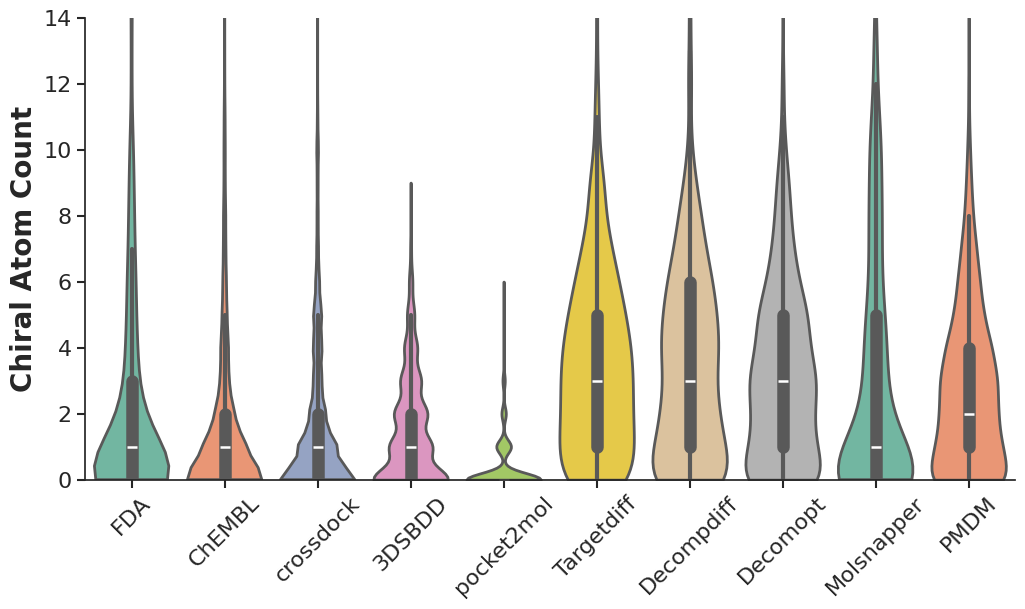

Running Tukey HSD test...
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
    3DSBDD     ChEMBL   0.1841 0.3796 -0.0676  0.4357  False
    3DSBDD   Decomopt   1.7943    0.0  1.4165   2.172   True
    3DSBDD Decompdiff   2.1193    0.0   1.737  2.5016   True
    3DSBDD        FDA   1.0099    0.0  0.7218   1.298   True
    3DSBDD Molsnapper   1.6589    0.0   1.267  2.0508   True
    3DSBDD       PMDM   1.2824    0.0  0.9164  1.6485   True
    3DSBDD Targetdiff   2.1681    0.0  1.8001  2.5362   True
    3DSBDD  crossdock     0.15 0.6419 -0.0947  0.3946  False
    3DSBDD pocket2mol  -1.1067    0.0 -1.4602 -0.7531   True
    ChEMBL   Decomopt   1.6102    0.0   1.294  1.9265   True
    ChEMBL Decompdiff   1.9352    0.0  1.6135  2.2569   True
    ChEMBL        FDA   0.8258    0.0   0.625  1.0267   True
    ChEMBL Molsnapper   1.4748    0.0  1.1418  1.8078   Tru

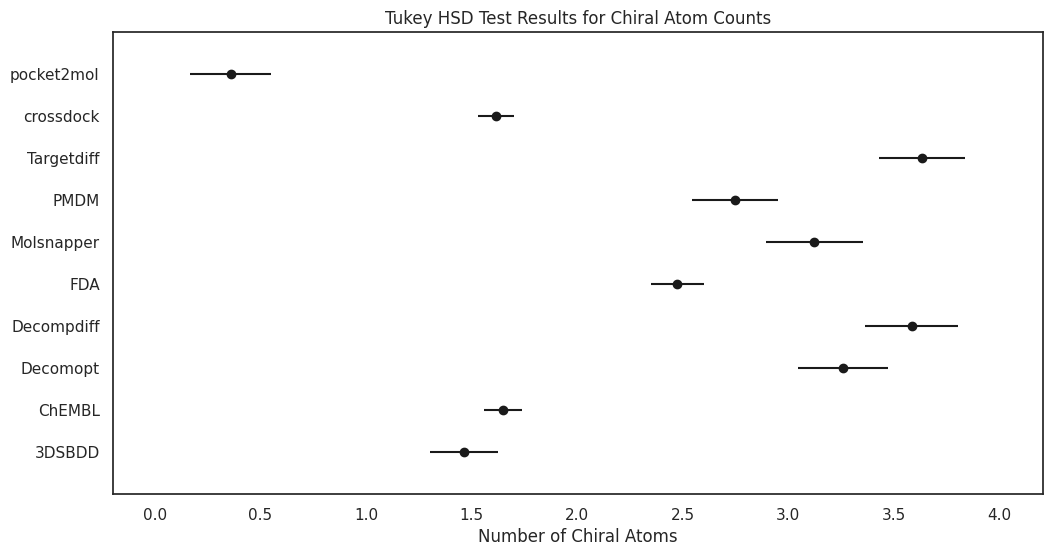

In [36]:
def calculate_chiral_atom_counts(smiles_list):
    """Calculate the number of chiral atoms for each molecule in the SMILES list."""
    chiral_atom_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Calculate the number of chiral centers
            chiral_centers = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
            chiral_atom_counts.append(len(chiral_centers))
    return chiral_atom_counts

def plot_chiral_atom_distribution_and_tukey(dfs, labels):
    """Plot the distribution of chiral atom counts and run Tukey HSD."""
    # Prepare data for violin plot and Tukey HSD
    data = []
    for df, label in zip(dfs, labels):
        chiral_atom_counts = calculate_chiral_atom_counts(df['SMILES'].tolist())
        data.extend([(label, count) for count in chiral_atom_counts])

    # Create a DataFrame for plotting and statistical testing
    plot_df = pd.DataFrame(data, columns=["Dataset", "Chiral Atom Count"])
    
    # Plotting the violin plot
    sns.set_theme(style="white")
    # Plotting the violin plot
    plt.figure(figsize=(12, 6))
    single_color = '#719AAC'
    sns.violinplot(x="Dataset", y="Chiral Atom Count", data=plot_df, palette="Set2", cut=0, linewidth=2)
    # plt.title("Molecular Weight Distributions", fontsize=18, fontweight="bold")
    # plt.xlabel("Dataset", fontsize=20, fontweight="bold")
    plt.xlabel("")
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel("Chiral Atom Count", fontsize=20, fontweight="bold")
    plt.ylim(0, 14)
    # plt.yticks([0, 2, 4, 6, 8])
    # Remove the top and right borders
    sns.despine(top=True, right=True, left=False, bottom=False)

    # Adjust the tick parameters for smaller ticks
    plt.tick_params(axis='both', which='major', direction='out', length=6, width=1.5)
    plt.gca().tick_params(bottom=True, left=True)
    
    output_path = "/home/yang2531/Desktop/Figures/chiralA_count_distribution_v1.png"  # Replace with your desired path
    plt.savefig(output_path, dpi=600, bbox_inches="tight")
    plt.show()

    # Tukey HSD test
    print("Running Tukey HSD test...")
    tukey_result = pairwise_tukeyhsd(
        endog=plot_df["Chiral Atom Count"],  # The numeric values
        groups=plot_df["Dataset"],          # The categorical group labels
        alpha=0.05                          # Significance level
    )
    print(tukey_result)

    # Optional: Visualize the Tukey HSD test result
    tukey_result.plot_simultaneous(figsize=(12, 6))
    plt.title("Tukey HSD Test Results for Chiral Atom Counts")
    plt.xlabel("Number of Chiral Atoms")
    plt.show()

# Example usage with a list of DataFrames and their labels
dfs = [df_fda, df_ChEMBL, df_crossdock, df_3DSBDD, df_p2m, df_targetdiff, df_decompdiff, df_decompopt, df_molsnapper, df_pmdm]  # Replace with your actual DataFrames
labels = ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomopt", "Molsnapper", "PMDM"]  # Replace with your actual labels

plot_chiral_atom_distribution_and_tukey(dfs, labels)

[14:21:37] WARNING: not removing hydrogen atom without neighbors
[14:21:38] WARNING: not removing hydrogen atom without neighbors
[14:21:38] WARNING: not removing hydrogen atom without neighbors
[14:21:38] WARNING: not removing hydrogen atom without neighbors
[14:21:38] WARNING: not removing hydrogen atom without neighbors


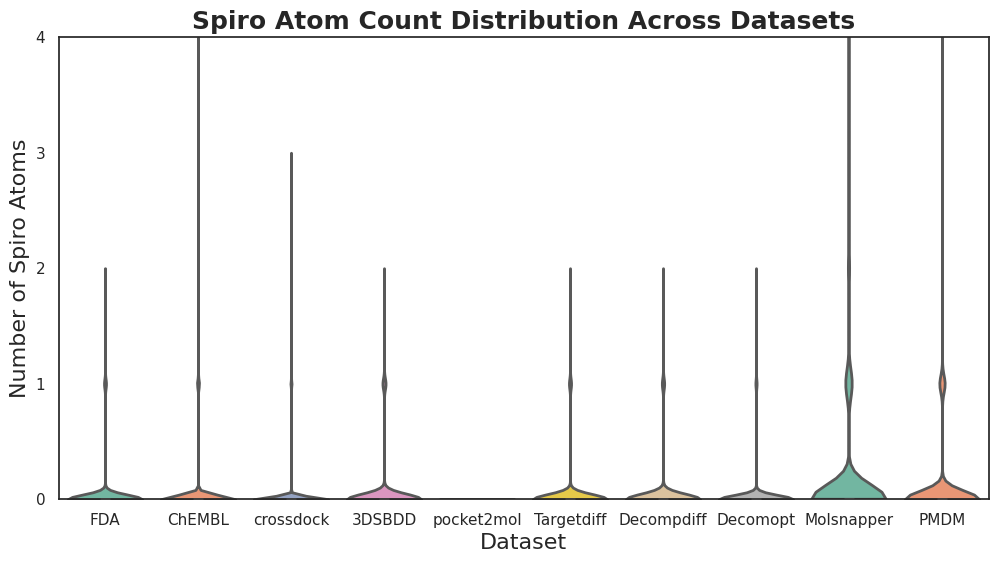

In [37]:
def calculate_spiro_atom_counts(smiles_list):
    """Calculate the number of spiro atoms for each molecule in the SMILES list."""
    spiro_atom_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Calculate the number of spiro atoms
            spiro_count = rdMolDescriptors.CalcNumSpiroAtoms(mol)
            spiro_atom_counts.append(spiro_count)
    return spiro_atom_counts

def plot_spiro_atom_distribution(dfs, labels):
    """Plot the distribution of spiro atom counts for multiple DataFrames as a violin plot."""
    # Prepare data for violin plot
    data = []
    for df, label in zip(dfs, labels):
        spiro_atom_counts = calculate_spiro_atom_counts(df['SMILES'].tolist())
        data.extend([(label, count) for count in spiro_atom_counts])

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(data, columns=["Dataset", "Spiro Atom Count"])
    
    # Plotting the violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(x="Dataset", y="Spiro Atom Count", data=plot_df, palette="Set2", cut=0, linewidth=2)
    
    # Customizing the plot
    plt.title("Spiro Atom Count Distribution Across Datasets", fontsize=18, fontweight="bold")
    plt.xlabel("Dataset", fontsize=16)
    plt.ylabel("Number of Spiro Atoms", fontsize=16)
    plt.ylim(0, 4)  # Adjust y-axis limit as per your data's range
    plt.yticks([0, 1, 2, 3, 4])
    plt.show()

# Example usage with a list of DataFrames and their labels
dfs = [df_fda, df_ChEMBL, df_crossdock, df_3DSBDD, df_p2m, df_targetdiff, df_decompdiff, df_decompopt, df_molsnapper, df_pmdm]  # Replace with your actual DataFrames
labels = ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomopt", "Molsnapper", "PMDM"]  # Replace with your actual labels

plot_spiro_atom_distribution(dfs, labels)

[14:21:41] WARNING: not removing hydrogen atom without neighbors
[14:21:42] WARNING: not removing hydrogen atom without neighbors
[14:21:42] WARNING: not removing hydrogen atom without neighbors
[14:21:42] WARNING: not removing hydrogen atom without neighbors
[14:21:42] WARNING: not removing hydrogen atom without neighbors


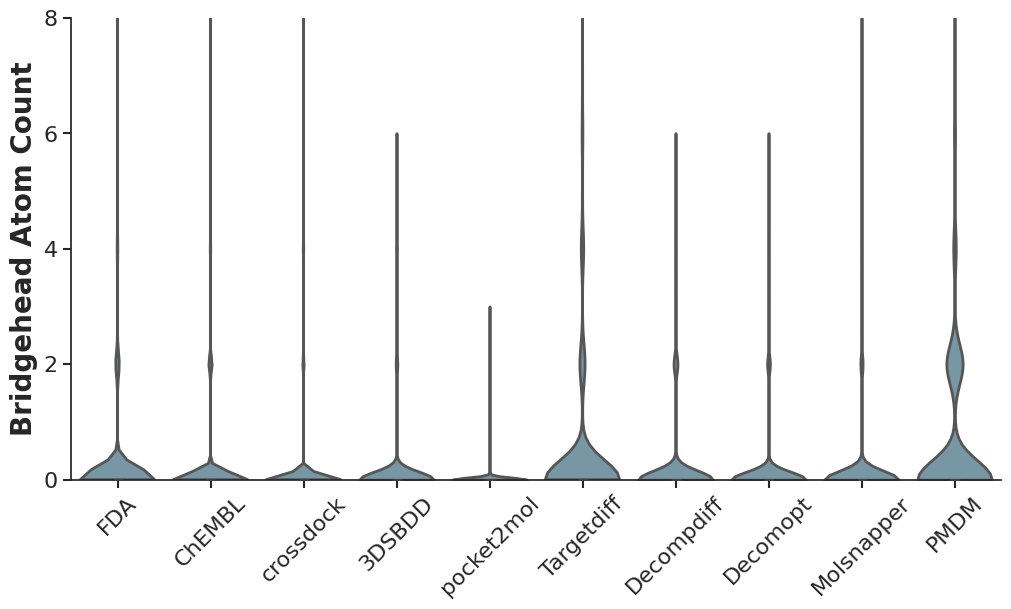

Running Tukey HSD test...
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
    3DSBDD     ChEMBL    0.036 0.7513 -0.0282  0.1003  False
    3DSBDD   Decomopt  -0.0027    1.0 -0.0991  0.0938  False
    3DSBDD Decompdiff   0.0364 0.9753 -0.0612   0.134  False
    3DSBDD        FDA   0.0894 0.0047  0.0158  0.1629   True
    3DSBDD Molsnapper  -0.0041    1.0 -0.1042  0.0959  False
    3DSBDD       PMDM   0.4956    0.0  0.4021   0.589   True
    3DSBDD Targetdiff   0.2916    0.0  0.1977  0.3856   True
    3DSBDD  crossdock  -0.0224  0.981 -0.0849    0.04  False
    3DSBDD pocket2mol  -0.0953 0.0287 -0.1856 -0.0051   True
    ChEMBL   Decomopt  -0.0387 0.8858 -0.1194   0.042  False
    ChEMBL Decompdiff   0.0004    1.0 -0.0817  0.0825  False
    ChEMBL        FDA   0.0533 0.0336  0.0021  0.1046   True
    ChEMBL Molsnapper  -0.0402 0.8947 -0.1252  0.0448  Fals

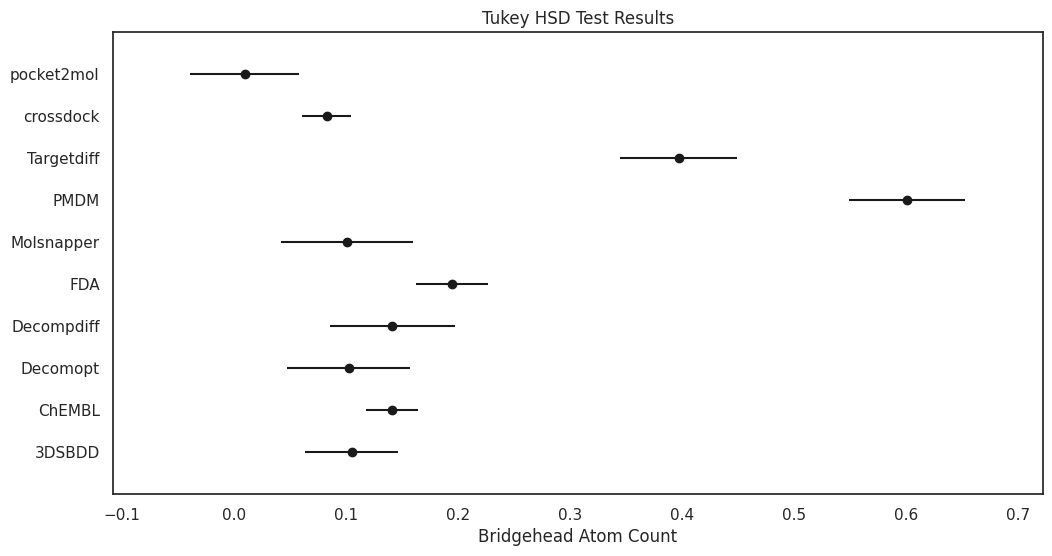

In [38]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def calculate_bridgehead_atom_counts(smiles_list):
    """Calculate the number of bridgehead atoms for each molecule in the SMILES list."""
    bridgehead_atom_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Calculate the number of bridgehead atoms
            bridgehead_count = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
            bridgehead_atom_counts.append(bridgehead_count)
    return bridgehead_atom_counts

def plot_bridgehead_atom_distribution_with_tukey(dfs, labels):
    """Plot the distribution of bridgehead atom counts and run Tukey HSD."""
    # Prepare data for violin plot and Tukey HSD
    data = []
    for df, label in zip(dfs, labels):
        bridgehead_atom_counts = calculate_bridgehead_atom_counts(df['SMILES'].tolist())
        data.extend([(label, count) for count in bridgehead_atom_counts])

    # Create a DataFrame for plotting and statistical testing
    plot_df = pd.DataFrame(data, columns=["Dataset", "Bridgehead Atom Count"])
    
    # Plotting the violin plot
    sns.set_theme(style="white")
    # Plotting the violin plot
    plt.figure(figsize=(12, 6))
    single_color = '#719AAC'
    sns.violinplot(x="Dataset", y="Bridgehead Atom Count", data=plot_df, palette=[single_color]*len(label), cut=0, linewidth=2)
    # plt.title("Molecular Weight Distributions", fontsize=18, fontweight="bold")
    # plt.xlabel("Dataset", fontsize=20, fontweight="bold")
    plt.xlabel("")
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel("Bridgehead Atom Count", fontsize=20, fontweight="bold")
    plt.ylim(0, 8)
    plt.yticks([0, 2, 4, 6, 8])
    # Remove the top and right borders
    sns.despine(top=True, right=True, left=False, bottom=False)

    # Adjust the tick parameters for smaller ticks
    plt.tick_params(axis='both', which='major', direction='out', length=6, width=1.5)
    plt.gca().tick_params(bottom=True, left=True)
    
    output_path = "/home/yang2531/Desktop/Figures/bridgeheadA_count_distribution_v2.png"  # Replace with your desired path
    plt.savefig(output_path, dpi=600, bbox_inches="tight")
    plt.show()

    # Tukey HSD test
    print("Running Tukey HSD test...")
    tukey_result = pairwise_tukeyhsd(
        endog=plot_df["Bridgehead Atom Count"],  # The numeric values
        groups=plot_df["Dataset"],              # The categorical group labels
        alpha=0.05                              # Significance level
    )
    print(tukey_result)

    # Optional: Visualize the Tukey HSD test result
    tukey_result.plot_simultaneous(figsize=(12, 6))
    plt.title("Tukey HSD Test Results")
    plt.xlabel("Bridgehead Atom Count")
    plt.show()

# Example usage with a list of DataFrames and their labels
dfs = [df_fda, df_ChEMBL, df_crossdock, df_3DSBDD, df_p2m, df_targetdiff, df_decompdiff, df_decompopt, df_molsnapper, df_pmdm]  # Replace with your actual DataFrames
labels = ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomopt", "Molsnapper", "PMDM"]  # Replace with your actual labels

plot_bridgehead_atom_distribution_with_tukey(dfs, labels)

[14:21:50] WARNING: not removing hydrogen atom without neighbors
[14:21:52] WARNING: not removing hydrogen atom without neighbors
[14:21:52] WARNING: not removing hydrogen atom without neighbors
[14:21:52] WARNING: not removing hydrogen atom without neighbors
[14:21:55] WARNING: not removing hydrogen atom without neighbors


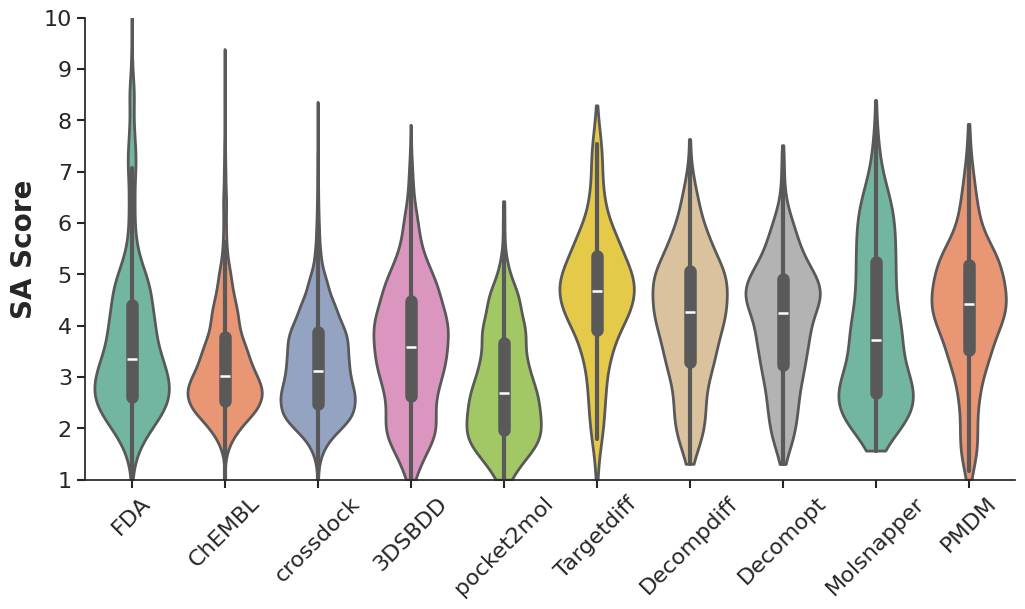

Running Tukey HSD test...
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
    3DSBDD     ChEMBL  -0.3282    0.0  -0.429 -0.2273   True
    3DSBDD   Decomopt   0.4999    0.0  0.3486  0.6513   True
    3DSBDD Decompdiff    0.601    0.0  0.4479  0.7542   True
    3DSBDD        FDA   0.1002 0.1554 -0.0152  0.2156  False
    3DSBDD Molsnapper   0.4002    0.0  0.2432  0.5572   True
    3DSBDD       PMDM   0.7265    0.0  0.5798  0.8732   True
    3DSBDD Targetdiff   1.0384    0.0  0.8909  1.1858   True
    3DSBDD  crossdock  -0.3562    0.0 -0.4542 -0.2582   True
    3DSBDD pocket2mol  -0.7493    0.0 -0.8909 -0.6076   True
    ChEMBL   Decomopt   0.8281    0.0  0.7014  0.9548   True
    ChEMBL Decompdiff   0.9292    0.0  0.8003  1.0581   True
    ChEMBL        FDA   0.4284    0.0  0.3479  0.5088   True
    ChEMBL Molsnapper   0.7283    0.0  0.5949  0.8618   Tru

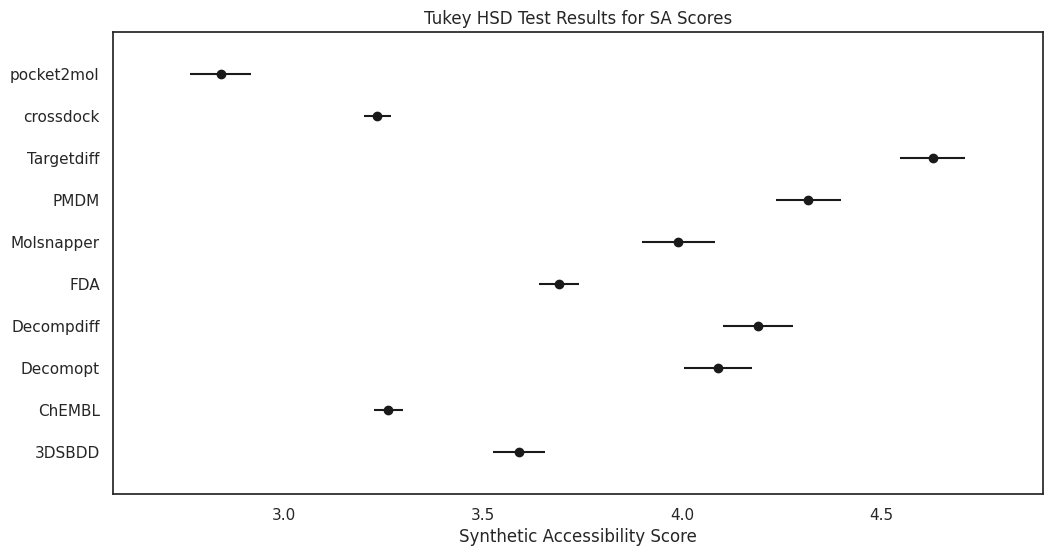

In [39]:
def calculate_sa_scores(smiles_list):
    """Calculate the synthetic accessibility (SA) score for each molecule in the SMILES list."""
    sa_scores = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Calculate the synthetic accessibility score
            sa_score = calculateScore(mol)
            sa_scores.append(sa_score)
    return sa_scores

def plot_sa_score_distribution_and_tukey(dfs, labels):
    """Plot the distribution of synthetic accessibility scores and run Tukey HSD."""
    # Prepare data for violin plot and Tukey HSD
    data = []
    for df, label in zip(dfs, labels):
        sa_scores = calculate_sa_scores(df['SMILES'].tolist())
        data.extend([(label, score) for score in sa_scores])

    # Create a DataFrame for plotting and statistical testing
    plot_df = pd.DataFrame(data, columns=["Dataset", "SA Score"])
    
    # Plotting the violin plot
    sns.set_theme(style="white")
    # Plotting the violin plot
    plt.figure(figsize=(12, 6))
    single_color = '#719AAC'
    sns.violinplot(x="Dataset", y="SA Score", data=plot_df, palette="Set2", cut=0, linewidth=2)
    # plt.title("Molecular Weight Distributions", fontsize=18, fontweight="bold")
    # plt.xlabel("Dataset", fontsize=20, fontweight="bold")
    plt.xlabel("")
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel("SA Score", fontsize=20, fontweight="bold")
    plt.ylim(1, 10)
    # plt.yticks([1,3,5,7,9])
    # Remove the top and right borders
    sns.despine(top=True, right=True, left=False, bottom=False)

    # Adjust the tick parameters for smaller ticks
    plt.tick_params(axis='both', which='major', direction='out', length=6, width=1.5)
    plt.gca().tick_params(bottom=True, left=True)
    
    output_path = "/home/yang2531/Desktop/Figures/SA_score_distribution_v1.png"  # Replace with your desired path
    plt.savefig(output_path, dpi=600, bbox_inches="tight")
    plt.show()

    # Tukey HSD test
    print("Running Tukey HSD test...")
    tukey_result = pairwise_tukeyhsd(
        endog=plot_df["SA Score"],  # The numeric values
        groups=plot_df["Dataset"],  # The categorical group labels
        alpha=0.05                  # Significance level
    )
    print(tukey_result)

    # Optional: Visualize the Tukey HSD test result
    tukey_result.plot_simultaneous(figsize=(12, 6))
    plt.title("Tukey HSD Test Results for SA Scores")
    plt.xlabel("Synthetic Accessibility Score")
    plt.show()

# Example usage with a list of DataFrames and their labels
dfs = [df_fda, df_ChEMBL, df_crossdock, df_3DSBDD, df_p2m, df_targetdiff, df_decompdiff, df_decompopt, df_molsnapper, df_pmdm]  # Replace with your actual DataFrames
labels = ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomopt", "Molsnapper", "PMDM"]  # Replace with your actual labels

plot_sa_score_distribution_and_tukey(dfs, labels)

### Figure 1

In [40]:
df_f1 = pd.read_csv('data/Benchmarking.csv', index_col=0)
df_f1

‘min_freq’ > 100  Pass PAINS filter  \
FDA                    0.786              0.962   
ChEMBL                 0.841              0.960   
crossdock              0.737              0.963   
3DSBDD                 0.439              0.991   
pocket2mol             0.602              0.968   
Targetdiff             0.217              0.978   
Decompdiff             0.476              0.979   
Decompopt              0.530              0.972   
Molsnapper             0.533              0.958   
PMDM                   0.227              0.942   

            Number of BM scaffolds exist in ZINC20  \
FDA                                          0.485   
ChEMBL                                       0.418   
crossdock                                    0.243   
3DSBDD                                       0.253   
pocket2mol                                   0.413   
Targetdiff                                   0.113   
Decompdiff                                   0.175   
Decompopt                                    0.216   
Molsnapper                                   0.130   
PMDM                                         0.118   

           Number of BM scaffolds exist in ZINC22  
FDA                                         0.513  
ChEMBL                                      0.428  
crossdock                                   0.328  
3DSBDD                                      0.279  
pocket2mol                                  0.431  
Targetdiff                                  0.132  
Decompdiff                                  0.229  
Decompopt                                   0.285  
Molsnapper                                  0.274  
PMDM                                       0.134

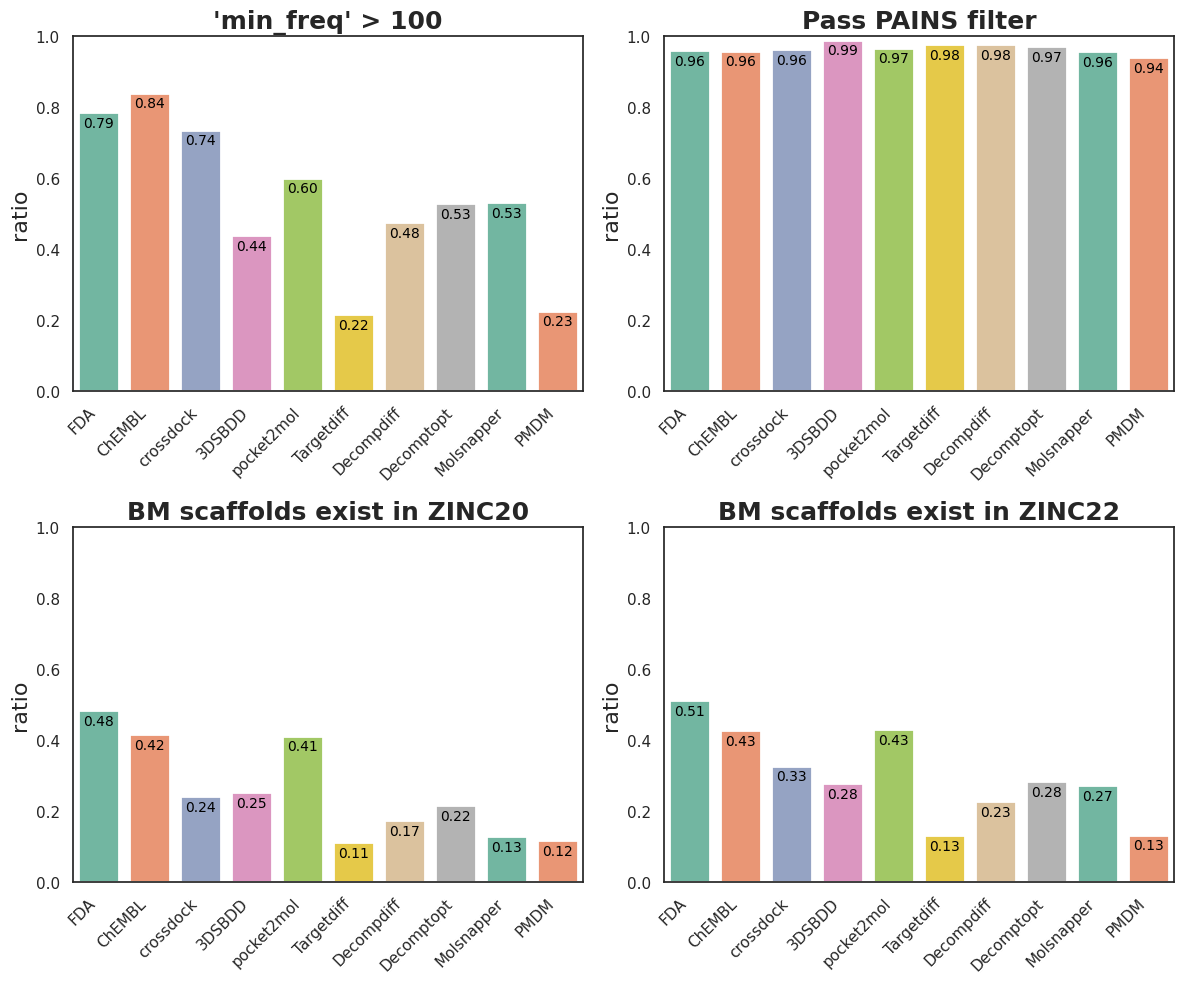

In [41]:
# Sample data based on your updated description (replace with your actual data)
data = {
    "Dataset": ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomptopt", "Molsnapper", "PMDM"],
    "'min_freq' > 100": [0.786, 0.841, 0.737, 0.439, 0.602, 0.217, 0.476, 0.530, 0.533, 0.227],
    "Pass PAINS filter": [0.962, 0.960, 0.963, 0.991, 0.968, 0.978, 0.979, 0.972, 0.958, 0.942],
    "BM scaffolds exist in ZINC20": [0.485, 0.418, 0.243, 0.253, 0.413, 0.113, 0.175, 0.216, 0.130, 0.118],
    "BM scaffolds exist in ZINC22": [0.513, 0.428, 0.328, 0.279, 0.431, 0.132, 0.229, 0.285, 0.274, 0.134]
}
df = pd.DataFrame(data).set_index("Dataset")

# Set up the figure and axes for a 2x2 grid of boxplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# List of columns to plotpalette
columns = df.columns

# Loop through each column to create individual boxplots with the index as x-axis labels
for i, ax in enumerate(axs.flatten()):
    sns.barplot(x=df.index, y=df[columns[i]], ax=ax, palette="Set2", linewidth=2, fill=True)
    ax.set_ylim(0, 1)  # Set y-axis limit to [0, 1]
    ax.set_title(columns[i], fontsize=18, fontweight="bold")  # Set title for each subplot
    ax.set_xticklabels(df.index, rotation=45, ha="right")  # Rotate x-axis labels for better readability
    ax.set_ylabel("ratio", fontsize=16)  # Change font size of y-axis label
    ax.set_xlabel("")
    for j, value in enumerate(df[columns[i]]):
        ax.text(j, value - 0.05, f'{value:.2f}', ha='center', va='bottom', fontsize=10, color='black')

     

plt.tight_layout()
plt.show()


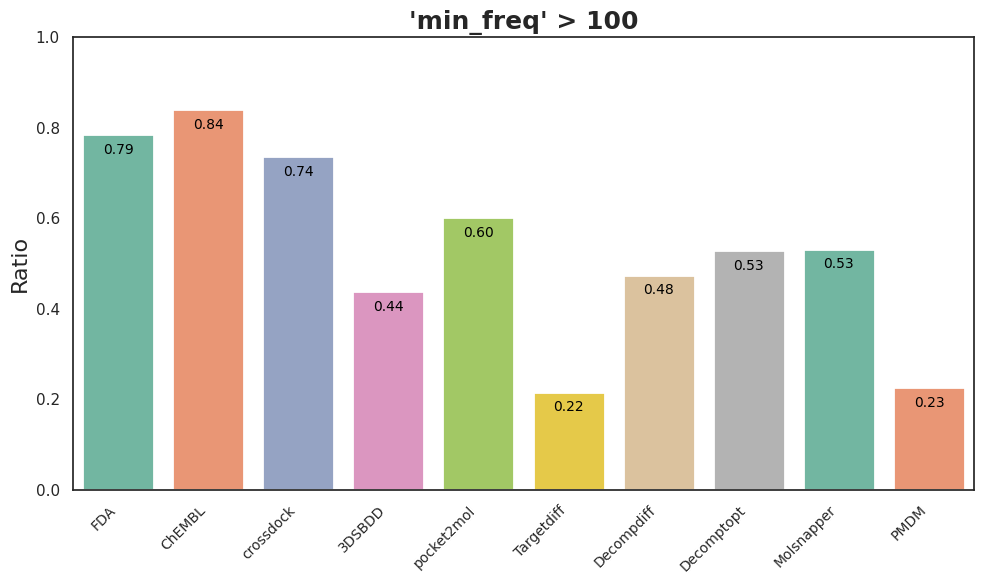

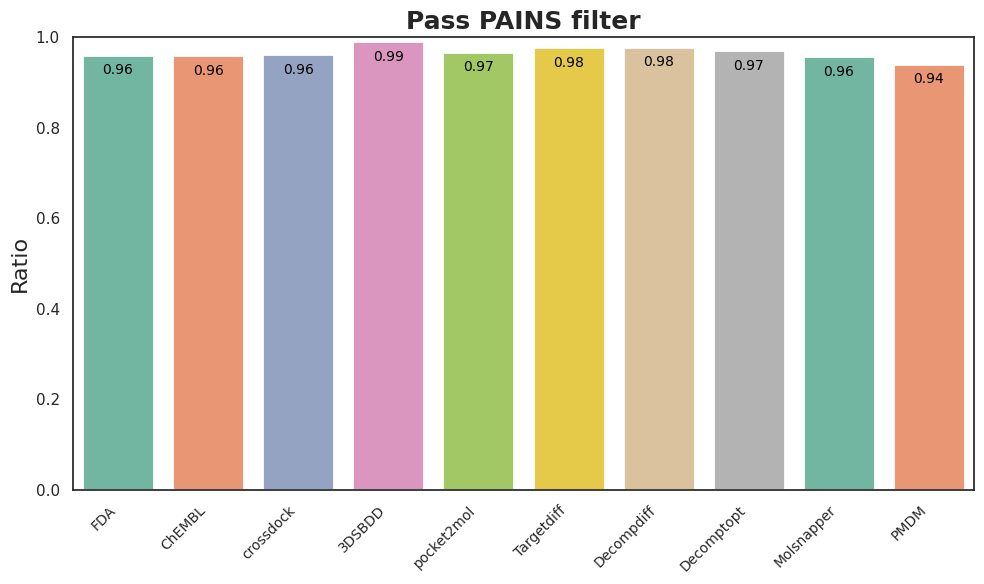

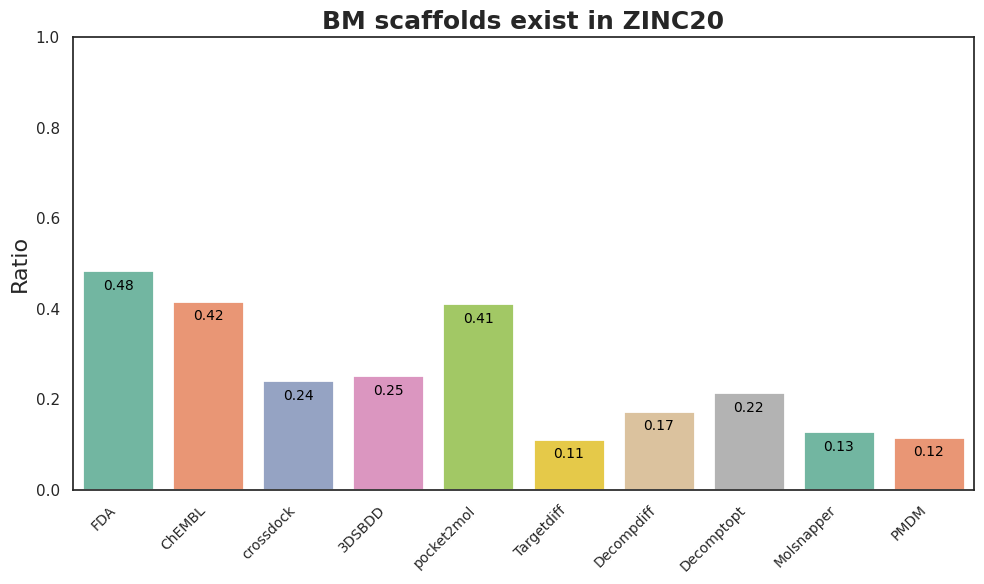

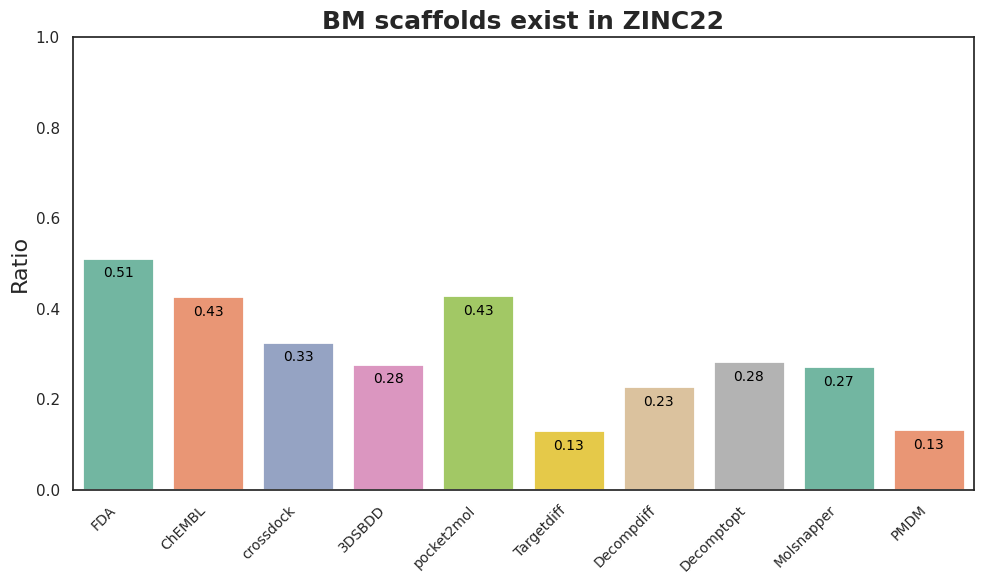

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data (replace with your actual data)
data = {
    "Dataset": ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomptopt", "Molsnapper", "PMDM"],
    "'min_freq' > 100": [0.786, 0.841, 0.737, 0.439, 0.602, 0.217, 0.476, 0.530, 0.533, 0.227],
    "Pass PAINS filter": [0.962, 0.960, 0.963, 0.991, 0.968, 0.978, 0.979, 0.972, 0.958, 0.942],
    "BM scaffolds exist in ZINC20": [0.485, 0.418, 0.243, 0.253, 0.413, 0.113, 0.175, 0.216, 0.130, 0.118],
    "BM scaffolds exist in ZINC22": [0.513, 0.428, 0.328, 0.279, 0.431, 0.132, 0.229, 0.285, 0.274, 0.134]
}
df = pd.DataFrame(data).set_index("Dataset")

# List of columns to plot
columns = df.columns

# Loop through each column and create a separate figure
for i in range(len(columns)):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=df.index, y=df[columns[i]], palette="Set2", linewidth=2)
    
    # Add title, labels, and y-axis limit
    plt.title(columns[i], fontsize=18, fontweight="bold")
    plt.ylabel("Ratio", fontsize=16)
    plt.xlabel("")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    
    # Add values on top of bars
    for j, value in enumerate(df[columns[i]]):
        plt.text(j, value - 0.05, f'{value:.2f}', ha='center', va='bottom', fontsize=10, color='black')
    
    # Show and save each figure (optional)
    plt.tight_layout()
    plt.show()
    # To save each plot as a file, uncomment the following line:
    # plt.savefig(f"{columns[i].replace(' ', '_')}.png", dpi=300)


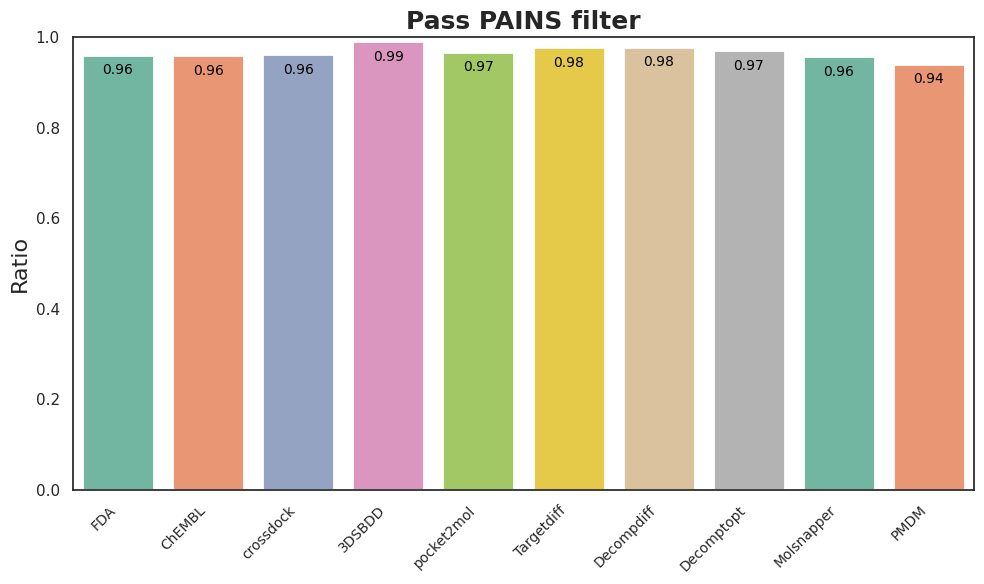

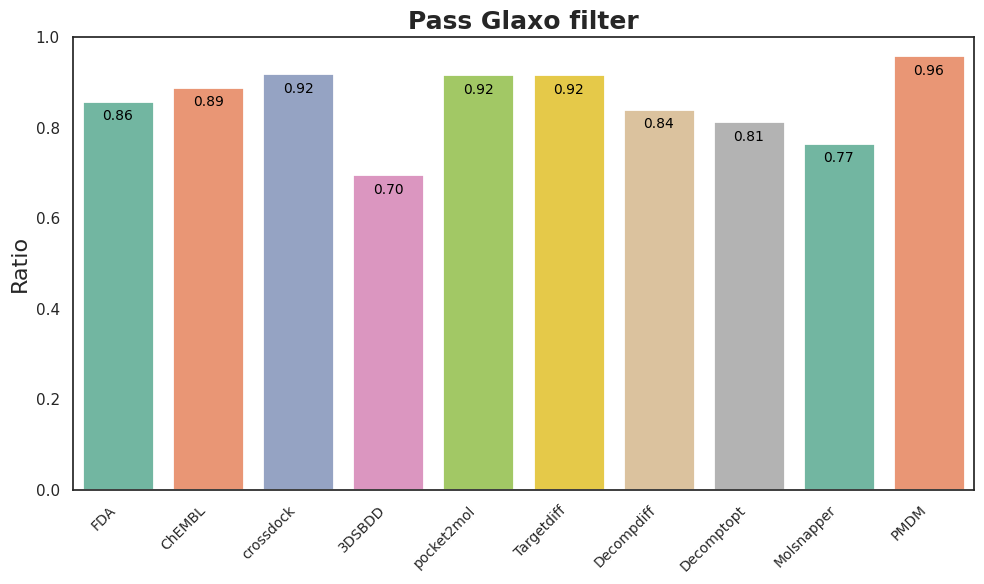

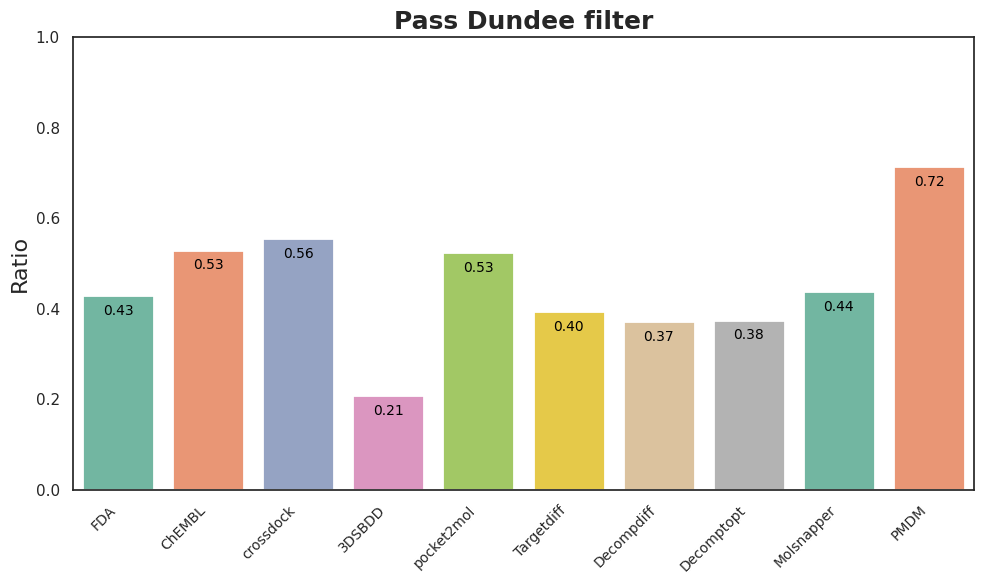

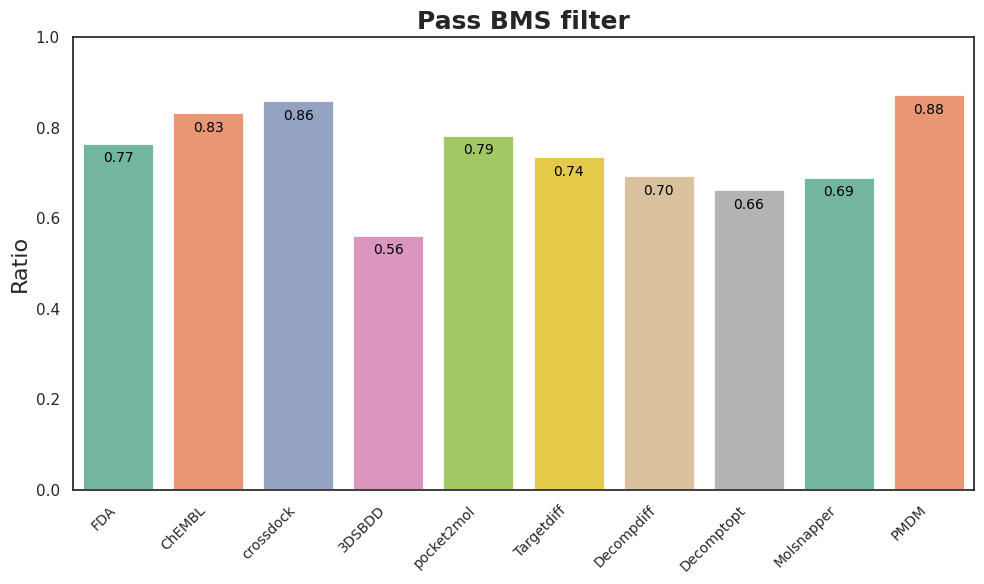

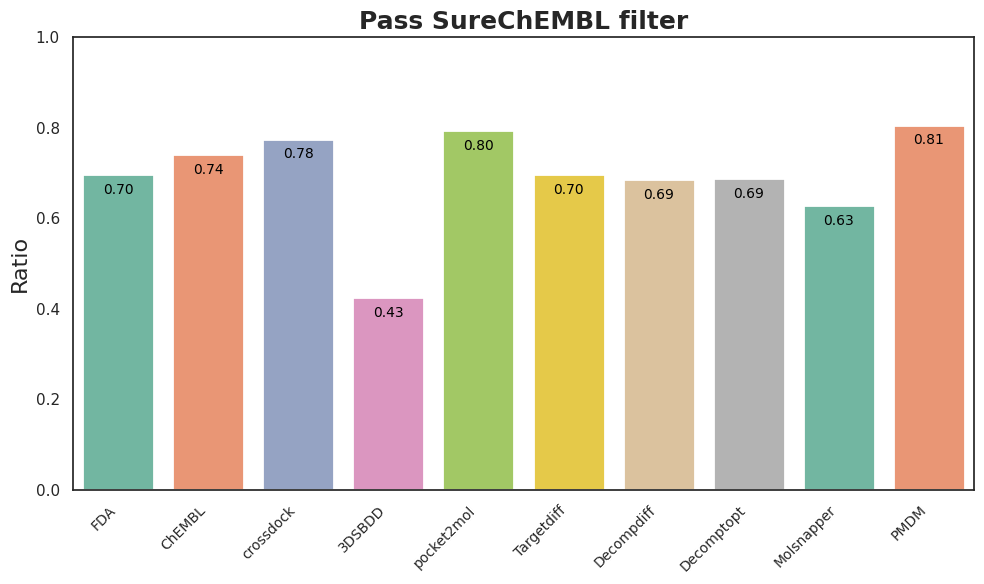

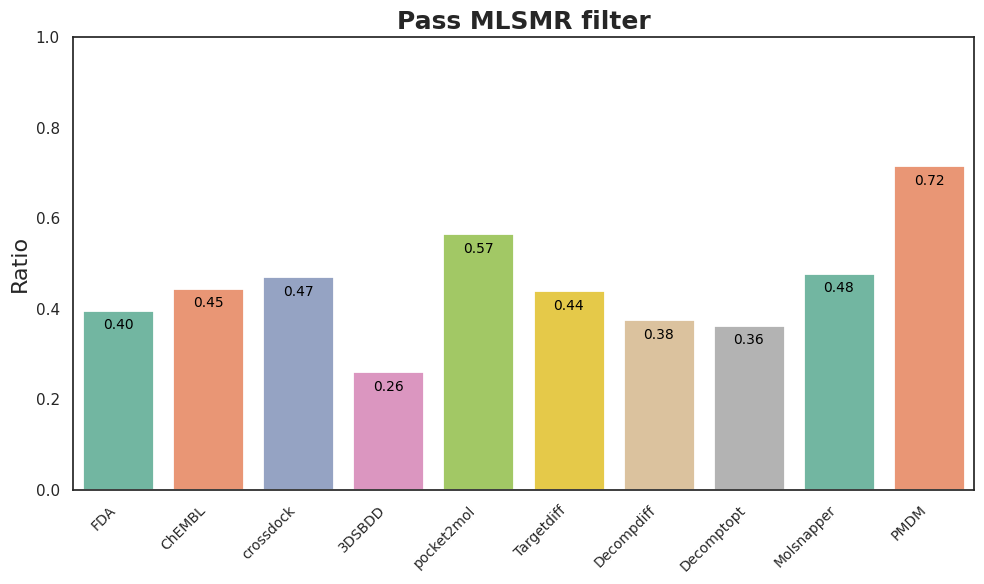

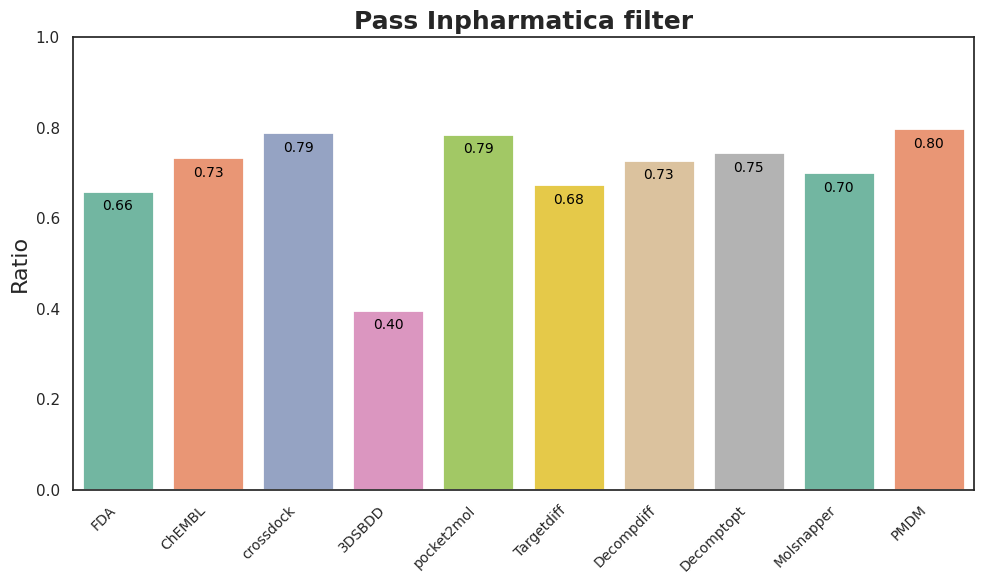

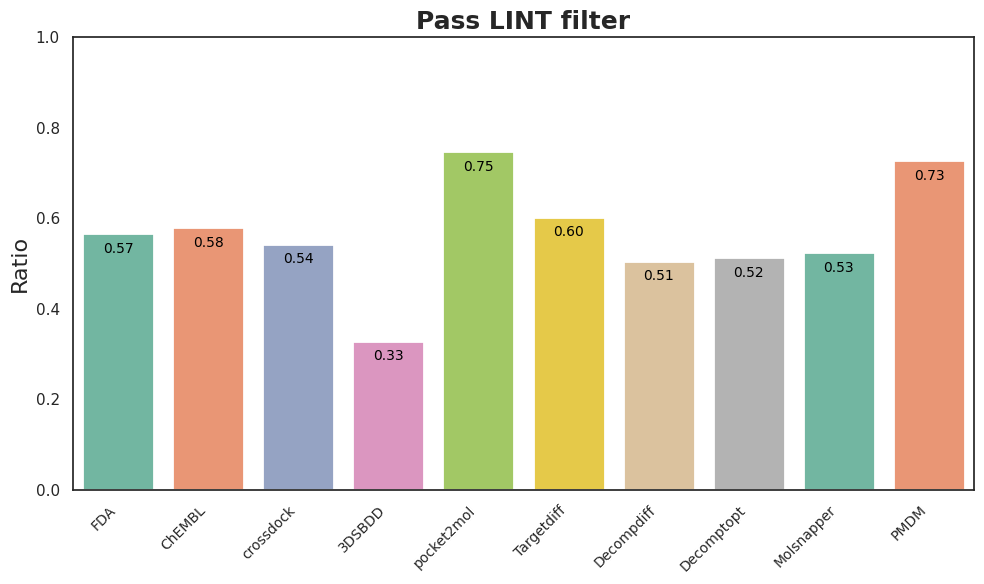

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data (replace with your actual data)
data = {
    "Dataset": ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomptopt", "Molsnapper", "PMDM"],
    "Pass PAINS filter": [0.962, 0.960, 0.963, 0.991, 0.968, 0.978, 0.979, 0.972, 0.958, 0.942],
    "Pass Glaxo filter": [0.860, 0.891, 0.921, 0.698, 0.919, 0.918, 0.842, 0.815, 0.767, 0.960],
    "Pass Dundee filter": [0.430, 0.531, 0.557, 0.209, 0.525, 0.395, 0.373, 0.376, 0.439, 0.716],
    "Pass BMS filter": [0.767, 0.835, 0.861, 0.564, 0.785, 0.738, 0.696, 0.664, 0.692, 0.875],
    "Pass SureChEMBL filter": [0.698, 0.742, 0.776, 0.426, 0.795, 0.697, 0.687, 0.689, 0.629, 0.807],
    "Pass MLSMR filter": [0.398, 0.447, 0.473, 0.262, 0.567, 0.441, 0.378, 0.365, 0.480, 0.718],
    "Pass Inpharmatica filter": [0.661, 0.735, 0.790, 0.398, 0.787, 0.676, 0.730, 0.746, 0.702, 0.800],
    "Pass LINT filter": [0.568, 0.580, 0.544, 0.330, 0.749, 0.604, 0.507, 0.515, 0.526, 0.729],
}
df = pd.DataFrame(data).set_index("Dataset")

# List of columns to plots
columns = df.columns

# Loop through each column and create a separate figure
for i in range(len(columns)):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=df.index, y=df[columns[i]], palette="Set2", linewidth=2)
    
    # Add title, labels, and y-axis limit
    plt.title(columns[i], fontsize=18, fontweight="bold")
    plt.ylabel("Ratio", fontsize=16)
    plt.xlabel("")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    
    # Add values on top of bars
    for j, value in enumerate(df[columns[i]]):
        plt.text(j, value - 0.05, f'{value:.2f}', ha='center', va='bottom', fontsize=10, color='black')
    
    # Show and save each figure (optional)
    plt.tight_layout()
    plt.show()
    # To save each plot as a file, uncomment the following line:
    # plt.savefig(f"{columns[i].replace(' ', '_')}.png", dpi=300)


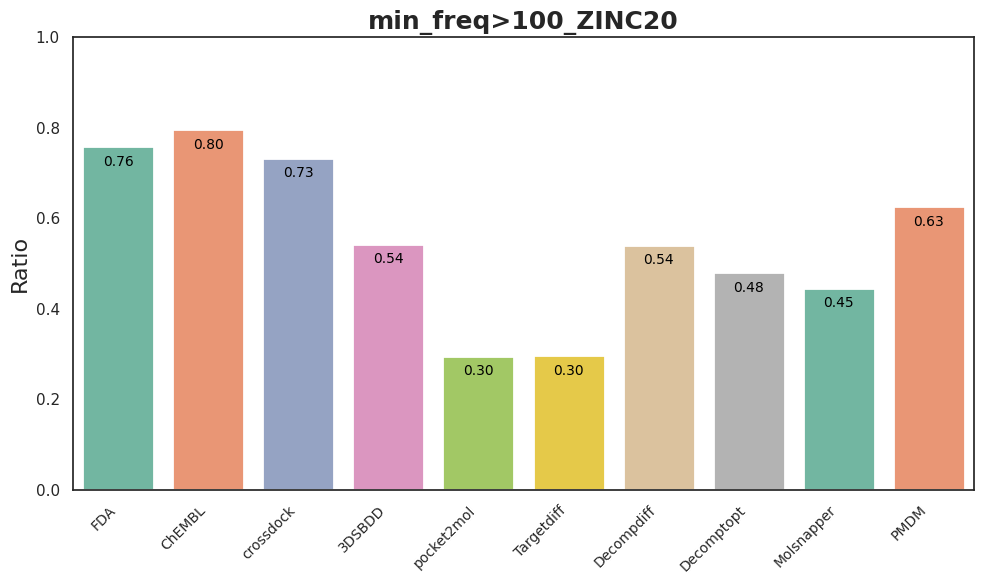

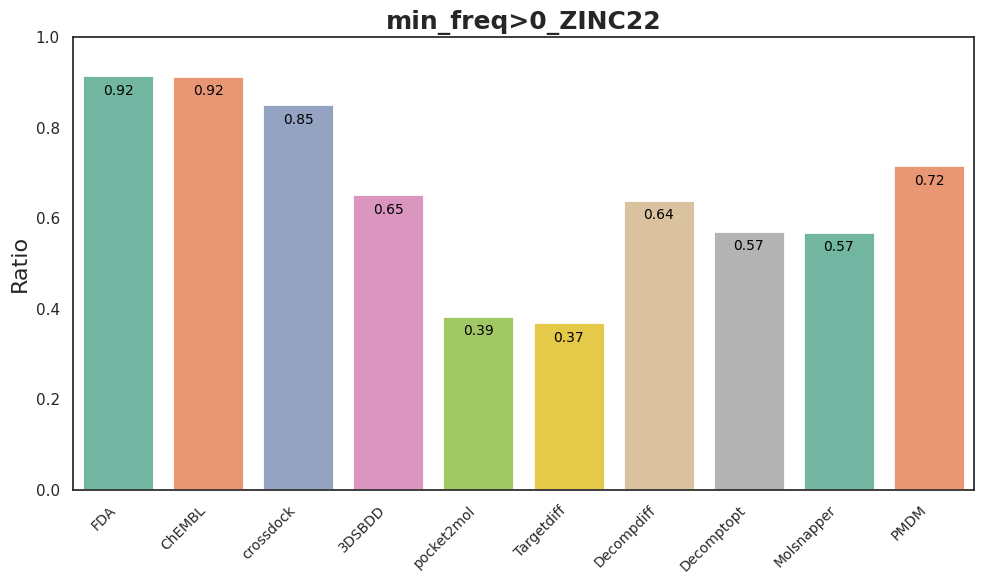

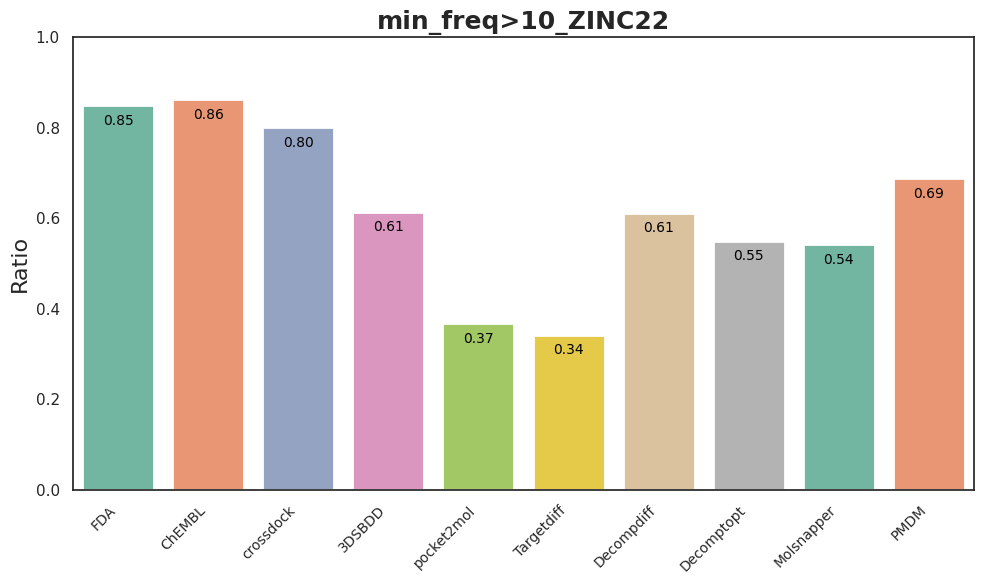

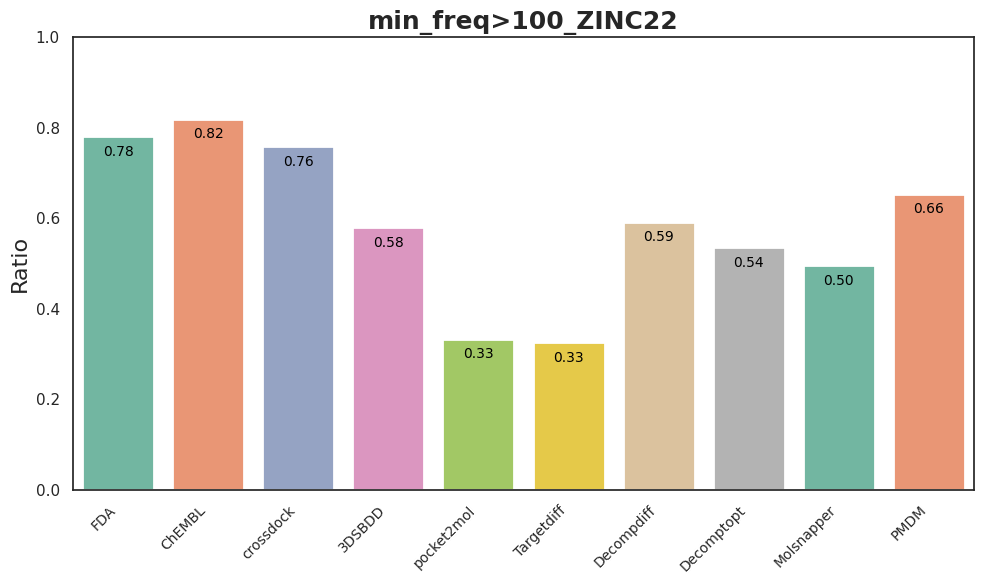

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data (replace with your actual data)
data = {
    "Dataset": ["FDA", "ChEMBL", "crossdock", "3DSBDD", "pocket2mol", "Targetdiff", "Decompdiff", "Decomptopt", "Molsnapper", "PMDM"],
    "min_freq>100_ZINC20": [0.759, 0.797, 0.734, 0.544, 0.297, 0.298, 0.542, 0.481, 0.447, 0.627],
    "min_freq>0_ZINC22": [0.917, 0.915, 0.853, 0.654, 0.385, 0.371, 0.641, 0.573, 0.571, 0.717],
    "min_freq>10_ZINC22": [0.850, 0.864, 0.801, 0.615, 0.368, 0.343, 0.613, 0.551, 0.543, 0.689],
    "min_freq>100_ZINC22": [0.781, 0.820, 0.760, 0.581, 0.334, 0.326, 0.593, 0.537, 0.497, 0.655],
}
df = pd.DataFrame(data).set_index("Dataset")

# List of columns to plots
columns = df.columns

# Loop through each column and create a separate figure
for i in range(len(columns)):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=df.index, y=df[columns[i]], palette="Set2", linewidth=2)
    
    # Add title, labels, and y-axis limit
    plt.title(columns[i], fontsize=18, fontweight="bold")
    plt.ylabel("Ratio", fontsize=16)
    plt.xlabel("")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    
    # Add values on top of bars
    for j, value in enumerate(df[columns[i]]):
        plt.text(j, value - 0.05, f'{value:.2f}', ha='center', va='bottom', fontsize=10, color='black')
    
    # Show and save each figure (optional)
    plt.tight_layout()
    plt.show()
    # To save each plot as a file, uncomment the following line:
    # plt.savefig(f"{columns[i].replace(' ', '_')}.png", dpi=300)

### structures that could pass all metrics

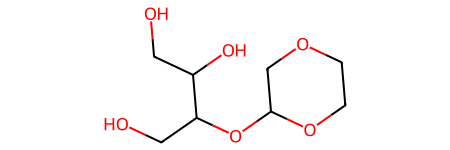

In [45]:
smiles_pass_metrics = "OCC(O)C(CO)OC1COCCO1"
mol = Chem.MolFromSmiles(smiles_pass_metrics)
mol

### Rings that filtered by ring system metric

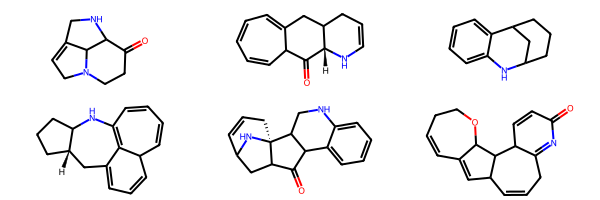

In [46]:
from rdkit import Chem
from rdkit.Chem import Draw

# List of SMILES strings (replace these with your own compounds)
smiles_list = [
    "O=C1CCN2CC=C3CNC1C32",                     # Ethanol
    "O=C1C2C=CC=CC=C2CC2CC=CN[C@H]12",                 # Acetic acid
    "c1ccc2c(c1)NC1CCCC2C1",             # Benzene
    "C1=CC2=C3C(=CC=CC3C=C1)C[C@@H]1CCCC1N2",               # Triethylamine
    "O=C1C2c3ccccc3NCC2[C@@]23CC=CC(CC12)N3",      # Acetanilide
    "O=C1C=CC2C(=N1)CC=CC1C=C3C=CCCOC3C12",                # Cyclohexane
]

# Convert SMILES to RDKit molecule objects
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

# Generate a grid image with RDKit
img = Draw.MolsToGridImage(
    mols,                      # List of molecules
    molsPerRow=3,              # Number of molecules per row
    subImgSize=(200, 100),     # Size of each molecule image  # Optional: add labels for each molecule
)

# Show the image
img
